# Regression on airfoil dataset

We import all the necessary packages into the notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import product
import seaborn as sns

We first load the training dataset *airfoil_noise_samples.csv* and test dataset *airfoil_noise_samples.csv* into pandas data frames. 

In [2]:
air_train = pd.read_csv('airfoil_noise_samples.csv')
air_test = pd.read_csv('airfoil_noise_test.csv')

We print the first few rows of the dataset and view the summary statistics of the dataset to inspect the dataset. The dataset does not have any missing values and seems cleaned.

In [3]:
air_train.head()

,Frequency,Angle,Displacement,Chord length,Velocity,Thickness,Sound Pressure
0,2175.611424,15.138865,21.075119,0.088194,66.764401,0.044771,122.365215
1,2962.923620,13.400893,13.200889,0.048462,78.221903,0.011041,129.296236
2,4430.810843,2.164599,13.959536,0.226743,57.053201,0.011499,121.827380
3,4939.695645,13.857682,18.203793,0.021705,23.896377,0.021475,114.998132
4,2193.979785,9.298757,11.007713,0.052737,38.917034,0.001741,125.639641


In [4]:
air_train.describe()

,Frequency,Angle,Displacement,Chord length,Velocity,Thickness,Sound Pressure
count,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000
mean,2941.719410,8.231085,13.552404,0.139788,51.407874,0.014286,123.970283
std,2782.566725,5.568032,4.693427,0.092304,16.438326,0.013974,4.775422
min,0.337305,0.001490,0.045842,0.000124,14.877552,0.000002,102.372432
25%,1044.921326,3.607908,10.655041,0.061642,36.962810,0.004142,120.890188
50%,2102.066627,7.486780,13.829518,0.125007,48.562733,0.008539,124.111408
75%,3976.531005,12.052639,16.810048,0.213330,67.863088,0.020909,127.204799
max,20884.888380,25.747061,26.970685,0.394016,87.053832,0.066562,140.469281


We now split the training dataset into predictor set `X_a_train` and target `y_a_train`. We will also split the test dataset into predictor set `X_a_test` and target `y_a_test`.

In [5]:
X_a_train = air_train.iloc[:,:-1]
y_a_train = air_train.iloc[:,-1]
X_a_test = air_test.iloc[:,:-1]
y_a_test = air_test.iloc[:,-1]

## Linear regression

We will add a columns of ones to the first column of `X_a_train` to accomodate the intercept term. The augemented matrix will be assigned to `X_a_train_aug`.

In [6]:
# augmented training inputs of size N x (D+1)
N, D = X_a_train.shape
X_a_train_aug = np.hstack([np.ones((N,1)), X_a_train])

We have to find $\beta$ that minimises the loss function. To minimise, find the value $\hat{\beta}$ where the gradient vanishes: $$\frac{dL}{d\beta}\bigg|_{\hat{\beta}}=0$$
Note that here we have X as the augemented training inputs and $\beta$ as the vector of coefficients including $\beta_0$. <br>
Expand the loss function:

\begin{align*} 
L(\beta) &= \frac{1}{2N}||y - X\beta||^2\\ 
&= \frac{1}{2N}[y - X\beta]^{T}[y - X\beta]\\
&= \frac{1}{2N}[y^{T}y - y^{T}X\beta - \beta^{T}X^{T}y + \beta^{T}X^{T}X\beta]
\end{align*}
It follows that:
\begin{align*}
\frac{dL(\beta)}{d\beta} &= \frac{1}{2N}[-X^{T}y - X^{T}y + 2X^{T}X\beta]\\
&= \frac{1}{2N}[-2X^{T}y + 2X^{T}X\beta]\\
&= \frac{1}{N}[-X^{T}y + X^{T}X\beta]
\end{align*}
In order to achieve $\frac{dL(\beta)}{d\beta}\big|_{\hat{\beta}}=0$, we arrive at:
\begin{align*}
-X^{T}y + X^{T}X\hat{\beta} &= 0 \\
X^{T}X\hat{\beta} &= X^{T}y \\
\hat{\beta} &= (X^{T}X)^{-1}X^{T}y
\end{align*}
We define the function `max_lik_estimate` to compute the $\hat{\beta}$ which minimises the loss function.

In [7]:
def max_lik_estimate(X, y):
    """
    Arguments:
        X: N x D matrix of training inputs
        y: N x 1 vector of training targets/observations
    
    Returns:
        beta_ml: D x 1 vector of parameters
    """
    N, D = X.shape
    beta_ml = np.linalg.solve(X.T @ X, X.T @ y)
    return beta_ml

In [8]:
beta_ml = max_lik_estimate(X_a_train_aug, y_a_train)
print(beta_ml)

[ 1.32599897e+02 -1.28512878e-03  1.49888731e-01 -8.37160618e-01
 -8.48764168e-01  1.04948547e-01 -9.70765098e-01]


Thus, the model parameters are:
$$\hat{\beta} = 
\begin{pmatrix}
-1.28512878 \times 10^{-3}\\
1.49888731 \times 10^{-1}\\
-8.37160618 \times 10^{-1}\\
-8.48764168 \times 10^{-1}\\
1.04948547 \times 10^{-1}\\
-9.70765098 \times 10^{-1}
\end{pmatrix}
$$
and $\hat{\beta_0}$ is a 6 x 1 vector with all elements equal to $1.32599897 \times 10^{2}$.

We define the function `predict_with_estimate` to compute the predicted y values.

In [9]:
def predict_with_estimate(X_test, beta):
    """"
    Arguments:
        X_test: matrix of test inputs
        beta: vector of parameters
    
    Returns: 
        prediction: vector of predicted values
    """
    
    prediction = X_test @ beta
    
    return prediction

In [10]:
y_pred = predict_with_estimate(X_a_train_aug, beta_ml)

We define the function `MSE` to compute the mean squared error:
$$\frac{1}{N}\sum^{N}_{i=1}{(y^{(i)}-\hat{y}^{(i)})^{2}}$$
where $\hat{y}$ is the predicted values of y.

In [11]:
def MSE(y_test, y_pred):
    """
    Arguments:
        y_test: vector of training targets/observations
        y_pred: vector of predicted values
    
    Returns:
        mean squared error between y_test and y_pred
    """
    return np.mean((y_test - y_pred)**2)

In [12]:
MSE_train_lr = MSE(y_a_train, y_pred)
print(r'MSE on training set:', MSE_train_lr)

MSE on training set: 1.8755566396401981


We define the function `r2_score` to compute the $R^{2}$ score:
$$1 - \frac{\sum^{N}_{i=1}{(y^{(i)}-\hat{y}^{(i)})^{2}}}{\sum^{N}_{i=1}{(y^{(i)}-\bar{y})^{2}}}$$
where $\bar{y}$ is the mean of y.

In [13]:
def r2_score(y_test, y_pred):
    """
    Arguments:
        y_test: vector of training targets/observations
        y_pred: vector of predicted values
    
    Returns:
        R^2 score between y_test and y_pred
    """
    numerator = np.sum((y_test - y_pred)**2) 
    y_avg = np.mean(y_test)
    denominator = np.sum((y_test - y_avg)**2)
    return 1 - numerator/denominator 

In [14]:
r2_train_lr = r2_score(y_a_train, y_pred)
print(r'R2 score on training set:', r2_train_lr)

R2 score on training set: 0.9177343977263077


We now apply the linear regression model on out test set to compute the out-of-sample MSE and $R^2$ score.

In [15]:
# augmented test inputs of size K x (D+1)
K, D = X_a_test.shape
X_a_test_aug = np.hstack([np.ones((K, 1)), X_a_test])

In [16]:
y_pred = predict_with_estimate(X_a_test_aug, beta_ml)
MSE_test_lr = MSE(y_a_test, y_pred)
r2_test_lr = r2_score(y_a_test, y_pred)

In [17]:
# Table of linear regression scores
data_lr = {'MSE': [MSE_train_lr, MSE_test_lr], 'R2 score': [r2_train_lr, r2_test_lr]}
df_lr = pd.DataFrame(data_lr, index=['Training', 'Test'])
df_lr = df_lr.style.set_properties(**{'font-size': '14pt'})
df_lr = df_lr.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_lr

,MSE,R2 score
Training,1.875557,0.917734
Test,1.984390,0.908317


The MSE on the training dataset is lower than the MSE on the test dataset. The $R^{2}$ score on the training dataset is higher than the $R^{2}$ on the test dataset. These are as expected because the training dataset should in general fit the linear regression model better than the test dataset as the model was built using the training dataset. 

## Lasso regression

Before we perform Lasso regression, Elastic net regression and k-Nearest Neighbour regression, the predictor sets will have to be standardised. <br>
We will standardise the `X_a_train` set using the formula: $$\frac{X - \mu}{\sigma}$$ where $\mu$ is the mean of X and $\sigma$ is the standard deviation of X. We define the function `standardise_train` to perform this procedure.

In [18]:
def standardise_train(X):
    """
    Arguments:
        X: training dataset
    
    Returns:
        X_std: standardised training dataset
    """
    mu = np.mean(X, 0)
    sigma = np.std(X, 0)
    X_std = (X - mu) / sigma
    return X_std

We have to standardise the test dataset `X_a_test` using the mean and standard deviation of the training dataset `X_a_train`. We will define the function `standardise_test` to perform this procedure.

In [19]:
def standardise_test(X_train, X_test):
    """
    Arguments:
        X_train: training dataset
        X_test: test dataset
    
    Returns:
        X_std: standardised test dataset
    """
    mu = np.mean(X_train, 0)
    sigma = np.std(X_train, 0)
    X_std = (X_test - mu) / sigma
    return X_std

The standardised `X_a_train` and `X_a_test` will be assigned to `X_a_train_s` and `X_a_test_s` respectively.

In [20]:
X_a_train_s = standardise_train(X_a_train)
X_a_test_s = standardise_test(X_a_train, X_a_test)

We will minimise the loss function:
$$L_{\mathrm{LASSO}}(\beta)=\frac{1}{2N}||y - X\beta -\beta_0||^2 + \lambda||\beta||_{1}$$
via gradient descent with a learning rate $l_{r}=1/N_{\mathrm{iterations}}$.<br>
We define the function `initialise` to initialise the parameters $\beta$ and $\beta_0$ with zeros.

In [21]:
def initialise(d):
    """    
    Argument:
        d: size of the beta vector (or number of parameters)
  
    Returns:
        beta: initialised vector of shape (d, 1)
        beta_0: initialised scalar (corresponds to the offset)
    """
  
    beta = np.zeros(shape=(d, 1), dtype=np.float32)
    beta_0 = 0
  
    assert(beta.shape==(d, 1))
    assert(isinstance(beta_0, float) or isinstance(beta_0, int))
    
    return beta, beta_0

Expand the loss function:
\begin{align*} 
L(\beta) &= \frac{1}{2N}||y - \beta X - \beta_0||^2 + \lambda||\beta||_{1}\\ 
&= \frac{1}{2N}[y - \beta X - \beta_0]^{T}[y - \beta X - \beta_0] + \lambda||\beta||_{1}\\
&= \frac{1}{2N}[y^{T}y - y^{T}X\beta - y^{T}\beta_0 - \beta^{T}X^{T}y + \beta^{T}X^{T}X\beta + \beta^{T}X^{T}\beta_0 -\beta_0^{T}y + \beta_0^{T}X\beta + \beta_0^{T}\beta_0] + \lambda||\beta||_{1}
\end{align*}
The derivative with respect to $\beta$ is:
\begin{align*}
\frac{dL(\beta)}{d\beta} &= \frac{1}{2N}[-X^{T}y - X^{T}y + 2X^{T}X\beta + X^{T}\beta_0 + X^{T}\beta_0] + \lambda sgn(\beta)\\
&= \frac{1}{2N}[-2X^{T}y + 2X^{T}X\beta + 2X^{T}\beta_0] + \lambda sgn(\beta)\\
&= \frac{1}{N}[-X^{T}y + X^{T}X\beta + X^{T}\beta_0] + \lambda sgn(\beta)
\end{align*}
where sgn(x) is the sign function.<br>
The derivative with respect to $\beta_0$ is:
\begin{align*}
\frac{dL(\beta)}{d\beta_0} &= \frac{1}{2N}[-y + X\beta - y + X\beta + 2\beta_0] \\
&= \frac{1}{2N}[-2y + 2X\beta + 2\beta_0] \\
&= \frac{1}{N}[-y + X\beta + \beta_0]
\end{align*}
We define the function `propogate_lasso` which implements the derivatives of the loss function with respect to $\beta$ and $\beta_0$.

In [22]:
def propagate_lasso(X, y, beta, beta_0, penalty):
    """
    Arguments:
        X: data of size (n, d)
        y: true label vector of size (n, 1)
        beta: parameters, a numpy array of size (d, 1)
        beta_0: offset, a scalar
        penalty: hyperparameter lambda for Lasso

    Returns:
        grads: dictionary which contains
            dbeta: gradient of the loss with respect to beta
            dbeta_0: gradient of the loss with respect to beta_0
    """
    n = X.shape[0]
    y = y.reshape(n, 1)

    # derivatives
    dbeta = (X.T @ (-y + X @ beta + beta_0)) / n + penalty * np.sign(beta)
    dbeta_0 = (-y + X @ beta + beta_0).mean()
    
    assert(dbeta.shape==beta.shape)
    assert(dbeta_0.dtype==float)
  
    # store gradients in a dictionary
    grads = {"dbeta": dbeta, "dbeta_0": dbeta_0}
  
    return grads

With the gradients, we define the function `optimise_lasso` that will implement the updating procedure for $\beta$
$$
\beta = \beta - l_{r} \ \frac{\partial \mathcal L}{\partial \beta}
$$
and for offset $\beta_0$
$$
\beta_0 = \beta_0 - l_{r} \ \frac{\partial \mathcal L}{\partial \beta_0} \, .
$$
with learning rate $l_{r}=1/N_{iterations}$.

In [23]:
def optimise_lasso(X, y, beta, beta_0, penalty, tolerance, num_iterations):
    """
    Arguments:
        X: data of size (n, d)
        y: true label vector of size (n, 1)
        beta: parameters, a numpy array of size (d, 1)
        beta_0: offset, a scalar
        penalty: hyperparameter lambda for Lasso
        tolerance: stopping criterion for optimisation
        num_iterations: maximum number of iterations for gradient descent

    Returns:
        params: dictionary containing the parameters beta and offset beta_0
    """
    # calculate gradients
    grads = propagate_lasso(X, y, beta, beta_0, penalty)

    # retrieve derivatives from grads
    dbeta = grads["dbeta"]
    dbeta_0 = grads["dbeta_0"]
    
    count = 1
    while np.linalg.norm(dbeta) > tolerance:

        # calculate gradients
        grads = propagate_lasso(X, y, beta, beta_0, penalty)
      
        # retrieve derivatives from grads
        dbeta = grads["dbeta"]
        dbeta_0 = grads["dbeta_0"]
      
        # updating procedure
        learning_rate = 1 / count
        beta = beta - learning_rate * dbeta
        beta_0 = beta_0 - learning_rate * dbeta_0
        
        count += 1
        # break if number of iterations exceeds maximum number of iterations
        if  count > num_iterations:
            break
  
    # save parameters in dictionary
    params = {"beta": beta, "beta_0": beta_0}
  
    return params

We now define functions to implement T-fold cross-validation to tune the Lasso penalty hyperparameter $\lambda$. <br>
The function `cross_val_split_np` produces the folds for training/validation split.

In [24]:
def cross_val_split_np(N, num_folds):
    """
    Arguments:
        N: number of rows in the dataset
        num_folds: number of folds for cross-validation
    
    Returns:
        folds: list containing lists of indices for each fold 
    """
    fold_size = N // num_folds
    index_perm = np.random.permutation(np.arange(N))
    folds = []
    for k in range(num_folds):
        folds.append(index_perm[k*fold_size:(k+1)*fold_size])
    return folds

The function `cross_val_evaluate_lasso` implements T-fold cross validation and returns the MSE for the training dataset and validation set at each training/validation split.

In [25]:
def cross_val_evaluate_lasso(X, y, num_folds, penalty, tolerance, num_iterations):
    """
    Arguments:
        X: data of size (n, d)
        y: true label vector of size (n, 1)
        num_folds: number of folds for cross-validation
        penalty: hyperparameter lambda for Lasso
        tolerance: stopping criterion for optimisation
        num_iterations: maximum number of iterations for gradient descent
    
    Returns:
        train_scores: list of training scores for each training/validation split
        val_scores: list of validation scores for each training/validation split
        beta: beta coefficient obtained from last training/validation split 
    """
    folds = cross_val_split_np(X.shape[0], num_folds)

    train_scores = []
    val_scores = []
  
    for i in range(len(folds)):

        val_indices = folds[i]
        train_indices = list(set(range(X.shape[0])) - set(val_indices))
        
        # define the training set
        X_train = X[train_indices, :] 
        y_train = y[train_indices].reshape(-1, 1)
    
        # define the validation set
        X_val = X[val_indices, :]  
        y_val = y[val_indices].reshape(-1,1) 
        
        # standardise X
        X_train_z = standardise_train(X_train)
        X_val_z = standardise_test(X_train, X_val)

        # train the model
        beta, beta_0 = initialise(X_train.shape[1])
        parameters = optimise_lasso(X_train_z, y_train, beta, beta_0, penalty, tolerance, num_iterations)
        beta = parameters["beta"]
        beta_0 = parameters["beta_0"]
        
        # predict the y values for training and validation set
        y_pred_train = X_train_z@beta + beta_0
        y_pred_val = X_val_z@beta + beta_0

        # evaluate the scores of the training and validation set
        train_score = MSE(y_train.reshape(-1,1), y_pred_train)
        val_score = MSE(y_val.reshape(-1,1), y_pred_val)
        
        # save the training scores and validation scores
        train_scores.append(train_score)
        val_scores.append(val_score)

    return train_scores, val_scores, beta

The function `find_best_penalty` loops through the list of penalty values to find the penalty which gives the lowest average MSE for the validation set.

In [26]:
def find_best_penalty(X, y, num_folds, penalty_list, tolerance, num_iterations):
    """
    Arguments:
        X: data of size (n, d)
        y: true label vector of size (n, d)
        num_folds: number of folds for cross-validation
        penalty_list: list of hyperparameters lambda for Lasso
        tolerance: stopping criterion for optimisation
        num_iterations: maximum number of iterations for gradient descent
    
    Returns:
        best_penalty: penalty which gives the lowest average MSE for the validation set
        best_mean_val: lowest average MSE for the validation set
        mean_train_list: list containing the average MSE for training set for each penalty
        mean_val_list: list containing the average MSE for validation set for each penalty
        beta_list: list containing beta coefficients obtained for each penalty at the last training/validation split
    """
    best_penalty = penalty_list[0]
    best_mean_val = float('inf')
    mean_train_list =[]
    mean_val_list = []
    beta_list = []
    for penalty in penalty_list:
        # compute MSE for each training/validation split
        train_scores, val_scores, beta = cross_val_evaluate_lasso(X, y, num_folds, penalty, tolerance, num_iterations)
        
        # compute average MSE
        mean_train = np.mean(train_scores)
        mean_val = np.mean(val_scores)
        # print("λ = {0}: mean training MSE is {1}, mean validation MSE is {2}".format(penalty, mean_train, mean_val))
        
        # store the average MSE for training and validation set and beta coefficients
        mean_train_list.append(mean_train)
        mean_val_list.append(mean_val)
        beta_list.append(beta)
        
        # update best penalty and lowest average MSE for validation set
        if mean_val < best_mean_val:
            best_penalty = penalty
            best_mean_val = mean_val
    return best_penalty, best_mean_val, mean_train_list, mean_val_list, beta_list

We now employ a 5-fold cross validation to tune the Lasso penalty hyperparameter $\lambda$.

In [27]:
penalty_list = np.exp(np.arange(-7, 1.25, 0.25, dtype=float))
best_penalty, best_mean_val, mean_train_list, mean_val_list, beta_list = find_best_penalty(X_a_train.to_numpy(), y_a_train.to_numpy(), 5, penalty_list, 0.01, num_iterations=100000)

We now plot a graph of $\log(\lambda)$ against average MSE on both the training set and validation set to find the optimal $\lambda$.

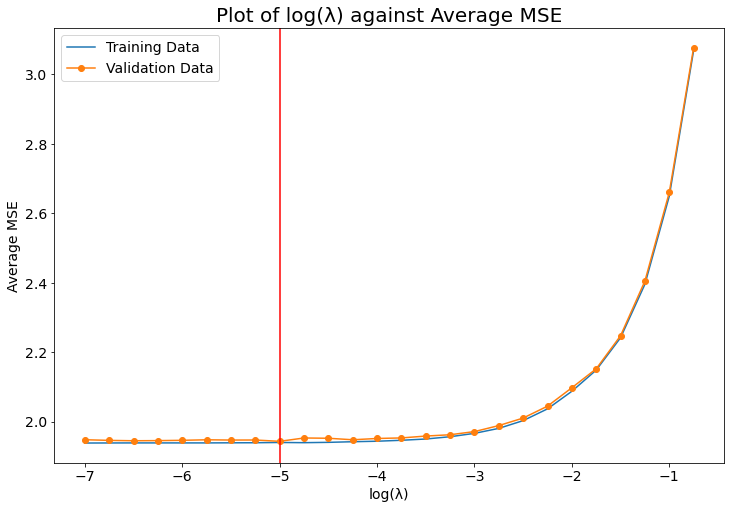

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(np.log(penalty_list)[:-7], mean_train_list[:-7], label="Training Data")
plt.plot(np.log(penalty_list)[:-7], mean_val_list[:-7], label="Validation Data", marker='o')
plt.axvline(x=np.log(best_penalty), color='r')
plt.xlabel("log(λ)", fontsize=14)
plt.ylabel("Average MSE", fontsize=14)
plt.title("Plot of log(λ) against Average MSE", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
ax.legend(loc="best",fontsize=14)
plt.show()

We observe that the average MSE remains almost constant for very small values of $\lambda$ and then increases exponentially after $\log(\lambda) = -3$. We also notice that the average MSE for the validation set is always slightly greater than the average MSE fo the training set. We choose the $\lambda$ with the minimum average MSE for the validation set. Thus,

In [29]:
print("The optimal value of λ is {}".format(best_penalty))

The optimal value of λ is 0.006737946999085467


We now plot a graph of $\log(\lambda)$ against the inferred parameters $\beta$.

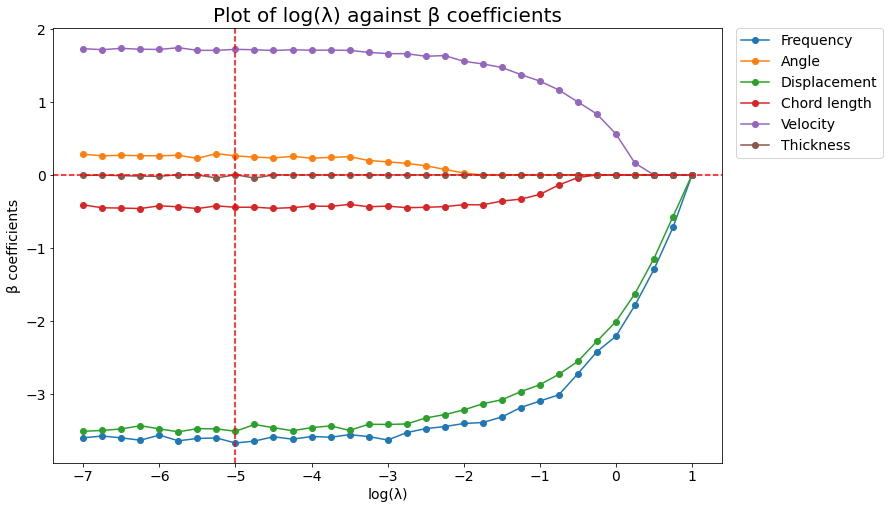

In [30]:
column_names = X_a_train.columns
fig, ax = plt.subplots(figsize=(12,8))
for i in range(X_a_train.shape[1]):
    plt.plot(np.log(penalty_list), [coef[i] for coef in beta_list], label="{}".format(column_names[i]), marker='o')
plt.axhline(y=0, color='r', linestyle='dashed')
plt.axvline(x=np.log(best_penalty), ymax=best_mean_val, color='r', linestyle='dashed')
plt.xlabel("log(λ)", fontsize=14)
plt.ylabel("β coefficients", fontsize=14)
plt.title("Plot of log(λ) against β coefficients", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=14)
plt.show()

We observe that the coefficients of the $\beta$ parameter shrinks towards zero as the value of the Lasso penalty $\lambda$ increases in the order of the predictors Thickness, Angle, Chord length, Velocity, Displacement and followed by Frequency. As $\lambda \rightarrow 0$, bias $\rightarrow 0$ as $\beta$ obtained will converge to the one obtained from least squares. As $\lambda \rightarrow \infty$, all the coefficients of $\beta$ will be shurnk to zero, thus bias $\rightarrow -\beta$. The variance thus decreases to zero. In conclusion, increasing $\lambda$ reduces the variance of the Lasso estimator but increases its bias. Thus, the optimal $\lambda$ will be the one which minimises the MSE.<br>
We notice that the optimal $\lambda$ is obtained when the predictor Thickness is has been shrunk towards zero, while the coefficients of the other predictors remain approximately constant, which implies that the predictor Thickness is less significant compared to the other predictors.

We will now retrain the model on the entire training dataset using the optimal $\lambda$ found above.

In [31]:
best_beta, best_beta_0 = initialise(X_a_train.shape[1])
best_beta= optimise_lasso(X_a_train_s.to_numpy(), y_a_train.to_numpy(), best_beta, best_beta_0, best_penalty, 0.001, num_iterations=1000000)

In [32]:
# training
y_pred = X_a_train_s.to_numpy() @ best_beta["beta"] + best_beta["beta_0"]
MSE_train_lasso = MSE(y_a_train.to_numpy().reshape(-1, 1), y_pred)
r2_train_lasso = r2_score(y_a_train.to_numpy().reshape(-1, 1), y_pred)

In [33]:
# test
y_pred = X_a_test_s.to_numpy() @ best_beta["beta"] + best_beta["beta_0"]
MSE_test_lasso = MSE(y_a_test.to_numpy().reshape(-1, 1), y_pred)
r2_test_lasso = r2_score(y_a_test.to_numpy().reshape(-1, 1), y_pred)

In [34]:
# Table of Lasso regression scores
data_lasso = {'MSE': [MSE_train_lasso, MSE_test_lasso], 'R2 score': [r2_train_lasso, r2_test_lasso]}
df_lasso = pd.DataFrame(data_lasso, index=['Training', 'Test'])
df_lasso = df_lasso.style.set_properties(**{'font-size': '14pt'})
df_lasso = df_lasso.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_lasso

,MSE,R2 score
Training,1.918305,0.915859
Test,2.072284,0.904256


The MSE on the training dataset is lower than the MSE on the test dataset. The $R^{2}$ score on the training dataset is higher than the $R^{2}$ on the test dataset. These are as expected because the training dataset should in general fit the Lasso regression model better than the test dataset as the model was built using the training dataset. <br>

In the case $\lambda=0$, lasso regression will be the same as the least squares problem in question 1.1. When comparing the coefficient of the predictor Thickness, the magnitude of the coefficient is $9.70765098 \times 10^{-1} $when $\lambda=0$, but is $1.03850288 \times 10^{-10}$ (approximately 0) when $\lambda$ equals the optimal value. This shows that Lasso has shrunk the coefficient of the predictor Thickness towards zero.

## Elastic Nets

We will minimise the loss function:
$$L_{\mathrm{EN}}(\beta)=\frac{1}{2N}||y - X\beta -\beta_0||^2 + \lambda[\alpha ||\beta||_{1} + (1 - \alpha)||\beta||^{2}]$$
via gradient descent with a learning rate $l_{r}=1/N_{\mathrm{iterations}}$.<br>
Expand the loss function:
\begin{align*} 
L(\beta) &= \frac{1}{2N}||y - \beta X - \beta_0||^2 + \lambda[\alpha ||\beta||_{1} + (1 - \alpha)||\beta||^{2}]\\ 
&= \frac{1}{2N}[y - \beta X - \beta_0]^{T}[y - \beta X - \beta_0] + \lambda[\alpha ||\beta||_{1} + (1 - \alpha)||\beta||^{2}]\\
&= \frac{1}{2N}[y^{T}y - y^{T}X\beta - y^{T}\beta_0 - \beta^{T}X^{T}y + \beta^{T}X^{T}X\beta + \beta^{T}X^{T}\beta_0 -\beta_0^{T}y + \beta_0^{T}X\beta + \beta_0^{T}\beta_0] + \lambda[\alpha ||\beta||_{1} + (1 - \alpha)||\beta||^{2}]
\end{align*}
The derivative with respect to $\beta$ is:
\begin{align*}
\frac{dL(\beta)}{d\beta} &= \frac{1}{2N}[-X^{T}y - X^{T}y + 2X^{T}X\beta + X^{T}\beta_0 + X^{T}\beta_0] + \lambda [\alpha sgn(\beta) + (1 - \alpha) 2 \beta]\\
&= \frac{1}{2N}[-2X^{T}y + 2X^{T}X\beta + 2X^{T}\beta_0] + \lambda [\alpha sgn(\beta) + (1 - \alpha) 2 \beta]\\
&= \frac{1}{N}[-X^{T}y + X^{T}X\beta + X^{T}\beta_0] + \lambda [\alpha sgn(\beta) + (1 - \alpha) 2 \beta]
\end{align*}
where sgn(x) is the sign function.<br>
The derivative with respect to $\beta_0$ is:
\begin{align*}
\frac{dL(\beta)}{d\beta_0} &= \frac{1}{2N}[-y + X\beta - y + X\beta + 2\beta_0] \\
&= \frac{1}{2N}[-2y + 2X\beta + 2\beta_0] \\
&= \frac{1}{N}[-y + X\beta + \beta_0]
\end{align*}
We define the function `propogate_elastic` which implements the derivatives of the loss function with respect to $\beta$ and $\beta_0$.

In [35]:
def propagate_elastic(X, y, beta, beta_0, penalty, alpha):
    """
    Arguments:
        X: data of size (n, d)
        y: true label vector of size (n, 1)
        beta: parameters, a numpy array of size (d, 1)
        beta_0: offset, a scalar
        penalty: regularisation strength
        alpha: coefficient that controls the relative importance of the Ridge and Lasso terms

    Returns:
        grads: dictionary which contains
            dbeta: gradient of the loss with respect to beta
            dbeta_0: gradient of the loss with respect to beta_0
    """
    n = X.shape[0]
    y = y.reshape(n, 1)

    # derivatives
    dbeta = (X.T @ (-y + X @ beta)) / n + penalty * (alpha * np.sign(beta) + (1 - alpha) * 2 * beta)
    dbeta_0 = (-y + X @ beta + beta_0).mean()

    assert(dbeta.shape==beta.shape)
    assert(dbeta_0.dtype==float)
  
    # store gradients in a dictionary
    grads = {"dbeta": dbeta, "dbeta_0": dbeta_0}
  
    return grads

With the gradients, we define the function `optimise_elastic` that will implement the updating procedure for $\beta$
$$
\beta = \beta - l_{r} \ \frac{\partial \mathcal L}{\partial \beta}
$$
and for offset $\beta_0$
$$
\beta_0 = \beta_0 - l_{r} \ \frac{\partial \mathcal L}{\partial \beta_0} \, .
$$
with learning rate $l_{r}=1/N_{iterations}$.

In [36]:
def optimise_elastic(X, y, beta, beta_0, penalty, alpha, tolerance, num_iterations):
    """
    Arguments:
        X: data of size (n, d)
        y: true label vector of size (n, 1)
        beta: parameters, a numpy array of size (d, 1)
        beta_0: offset, a scalar
        penalty: regularisation strength
        alpha: coefficient that controls the relative importance of the Ridge and Lasso terms
        tolerance: stopping criterion for optimisation
        num_iterations: maximum number of iterations for gradient descent

    Returns:
        params: dictionary containing the parameters beta and offset beta_0
    """
    # calculate cost and gradients
    grads = propagate_elastic(X, y, beta, beta_0, penalty, alpha)

    # retrieve derivatives from grads
    dbeta = grads["dbeta"]
    dbeta_0 = grads["dbeta_0"]
    
    count = 1
    while np.linalg.norm(dbeta) > tolerance:

        # calculate gradients
        grads = propagate_elastic(X, y, beta, beta_0, penalty, alpha)
      
        # retrieve derivatives from grads
        dbeta = grads["dbeta"]
        dbeta_0 = grads["dbeta_0"]
      
        # updating procedure
        learning_rate = 1 / count
        beta = beta - learning_rate * dbeta
        beta_0 = beta_0 - learning_rate * dbeta_0
        
        count += 1
        # break if number of iterations exceeds maximum number of iterations
        if  count > num_iterations:
            break
  
    # save parameters and gradients in dictionary
    params = {"beta": beta, "beta_0": beta_0}
  
    return params

We now define functions to implement grid search and T-fold cross-validation to tune the regularisation strength $\lambda$ for 3 different values of $\alpha$: 0.1, 0.5 and 0.9. <br>
The function `cross_val_evaluate_elastic` implements T-fold cross validation and returns the MSE for the training dataset and validation set at each training/validation split.

In [37]:
def cross_val_evaluate_elastic(X, y, num_folds, penalty, alpha, tolerance, num_iterations):
    """
    Arguments:
        X: data of size (n, d)
        y: true label vector of size (n, 1)
        num_folds: number of folds for cross-validation
        penalty: regularisation strength
        alpha: coefficient that controls the relative importance of the Ridge and Lasso terms
        tolerance: stopping criterion for optimisation
        num_iterations: maximum number of iterations for gradient descent
    
    Returns:
        train_scores: list of training scores for each training/validation split
        val_scores: list of validation scores for each training/validation split
        beta: beta coefficient obtained from last training/validation split 
    """
    folds = cross_val_split_np(X.shape[0], num_folds)

    train_scores = []
    val_scores = []
  
    for i in range(len(folds)):

        val_indices = folds[i]
        train_indices = list(set(range(X.shape[0])) - set(val_indices))
        
        # define the training set
        X_train = X[train_indices, :] 
        y_train = y[train_indices]
    
        # define the validation set
        X_val = X[val_indices, :]  
        y_val = y[val_indices] 

        # standardise X
        X_train_z = standardise_train(X_train)
        X_val_z = standardise_test(X_train, X_val)

        # train the model
        beta, beta_0 = initialise(X_train.shape[1])
        parameters = optimise_elastic(X_train_z, y_train, beta, beta_0, penalty, alpha, tolerance, num_iterations)
        beta = parameters["beta"]
        beta_0 = parameters["beta_0"]
        
        # predict the y values for training and validation set
        y_pred_train = X_train_z@beta + beta_0
        y_pred_val = X_val_z@beta + beta_0

        # evaluate the scores of the training and validation set
        train_score = MSE(y_pred_train, np.reshape(y_train, (-1,1)))
        val_score = MSE(y_pred_val, np.reshape(y_val, (-1,1)))
        
        # store the training scores and validation scores
        train_scores.append(train_score)
        val_scores.append(val_score)

    return train_scores, val_scores, beta

The function `grid_search_elastic` loops through the list of penalty values to find the penalty which gives the lowest average MSE for the validation set for each 3 different values of $\alpha$: 0.1, 0.5 and 0.9.

In [38]:
def grid_search_elastic(X, y, num_folds, hyperparameters, tolerance, num_iterations):
    """
    Arguments:
        X: data of size (n, d)
        y: true label vector of size (n, d)
        num_folds: number of folds for cross-validation
        penalty_list: list of hyperparameters lambda for Lasso
        tolerance: stopping criterion for optimisation
        num_iterations: maximum number of iterations for gradient descent
    
    Returns:
        best_penalty: penalty which gives the lowest average MSE for the validation set
        best_mean_val: lowest average MSE for the validation set
        mean_train_list: list containing the average MSE for training set for each penalty
        mean_val_list: list containing the average MSE for validation set for each penalty
        beta_list: list containing beta coefficients obtained for each penalty at the last training/validation split 
    """
    penalty_list = hyperparameters["penalty"]
    alpha_list = hyperparameters["alpha"]
    best_penalty_list = []
    best_mean_val_list = []
    mean_vals = []
    mean_trains = []
    for alpha in alpha_list:
        best_penalty = penalty_list[0]
        best_mean_val = float('inf')
        mean_val_list = []
        mean_train_list = []
        for penalty in penalty_list:
            # compute MSE for each training/validation split
            train_scores, val_scores, beta = cross_val_evaluate_elastic(X, y, num_folds, penalty, alpha, tolerance, num_iterations)
            
            # compute average MSE
            mean_train = np.mean(train_scores)
            mean_val = np.mean(val_scores)
            # print("α = {0}, λ = {1}: mean training MSE is {2}, mean validation MSE is {3}".format(alpha, penalty, mean_train, mean_val))
            
            # store the average MSE for training and validation set
            mean_train_list.append(mean_train)
            mean_val_list.append(mean_val)
            
            # update best penalty and lowest average MSE for validation set
            if mean_val < best_mean_val:
                best_penalty = penalty
                best_mean_val = mean_val
        best_penalty_list.append(best_penalty)
        best_mean_val_list.append(best_mean_val)
        mean_vals.append(mean_val_list)
        mean_trains.append(mean_train_list)
    return best_penalty_list, best_mean_val_list, mean_vals, mean_trains

We now employ a grid search and 5-fold cross validation to tune the regularisation strength $\lambda$ with respect to the 3 different values of $\alpha$: 0.1, 0.5 and 0.9.

In [39]:
penalty_list = np.exp(np.arange(-9, -2, 0.25, dtype=float))
hyperparameters = {"penalty": penalty_list, "alpha":[0.1, 0.5, 0.9]}
best_penalty_list, best_mean_val_list, mean_vals, mean_trains = grid_search_elastic(X_a_train.to_numpy(), y_a_train.to_numpy(), 5, hyperparameters, 0.01, 100000)

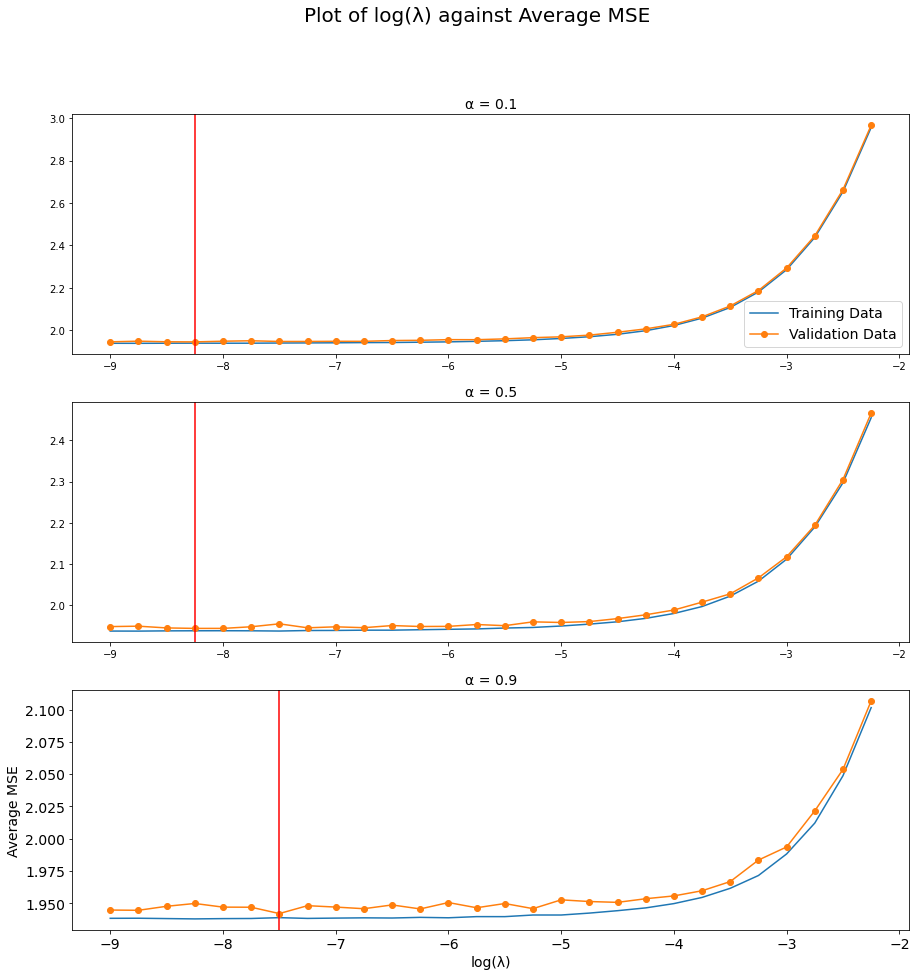

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 15))
fig.suptitle('Plot of log(λ) against Average MSE', fontsize=20)
# α = 0.1
ax1.plot(np.log(penalty_list), mean_trains[0], label="Training Data")
ax1.plot(np.log(penalty_list), mean_vals[0], label="Validation Data", marker='o')
ax1.axvline(x=np.log(best_penalty_list[0]), color='r')
ax1.legend(loc="best", fontsize=14)
ax1.set_title("α = 0.1", fontsize=14)

# α = 0.5
ax2.plot(np.log(penalty_list), mean_trains[1], label="Training Data")
ax2.plot(np.log(penalty_list), mean_vals[1], label="Validation Data", marker='o')
ax2.axvline(x=np.log(best_penalty_list[1]), color='r')
ax2.set_title("α = 0.5", fontsize=14)

# α = 0.9
ax3.plot(np.log(penalty_list), mean_trains[2], label="Training Data")
ax3.plot(np.log(penalty_list), mean_vals[2], label="Validation Data", marker='o')
ax3.axvline(x=np.log(best_penalty_list[2]), color='r')
ax3.set_title("α = 0.9", fontsize=14)

plt.xlabel("log(λ)", fontsize=14)
plt.ylabel("Average MSE", fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

In [41]:
print("For α = 0.1, the optimal λ is {}".format(best_penalty_list[0]))
print("For α = 0.5, the optimal λ is {}".format(best_penalty_list[1]))
print("For α = 0.9, the optimal λ is {}".format(best_penalty_list[2]))

For α = 0.1, the optimal λ is 0.00026125855730166754
For α = 0.5, the optimal λ is 0.00026125855730166754
For α = 0.9, the optimal λ is 0.0005530843701478336


We will now retrain the model on the entire training dataset using the optimal $\lambda$ found above for the 3 different values of $\alpha$: 0.1, 0.5 and 0.9.

In [42]:
beta, beta_0 = initialise(X_a_train.shape[1])
beta01 = optimise_elastic(X_a_train_s.to_numpy(), y_a_train.to_numpy(), beta, beta_0, best_penalty_list[0], 0.1, 0.001, num_iterations=100000)
beta05 = optimise_elastic(X_a_train_s.to_numpy(), y_a_train.to_numpy(), beta, beta_0, best_penalty_list[1], 0.5, 0.001, num_iterations=100000)
beta09 = optimise_elastic(X_a_train_s.to_numpy(), y_a_train.to_numpy(), beta, beta_0, best_penalty_list[2], 0.9, 0.001, num_iterations=100000)

In [43]:
# alpha = 0.1
# training
y_pred = X_a_train_s.to_numpy() @ beta01["beta"] + beta01["beta_0"]
MSE_train_en_01 = MSE(y_a_train.to_numpy().reshape(-1,1), y_pred)
r2_train_en_01 = r2_score(y_a_train.to_numpy().reshape(-1,1), y_pred) 

# test 
y_pred = X_a_test_s.to_numpy() @ beta01["beta"] + beta01["beta_0"]
MSE_test_en_01 = MSE(y_a_test.to_numpy().reshape(-1,1), y_pred)
r2_test_en_01 = r2_score(y_a_test.to_numpy().reshape(-1,1), y_pred)

In [44]:
# alpha = 0.5
# training
y_pred = X_a_train_s.to_numpy() @ beta05["beta"] + beta05["beta_0"]
MSE_train_en_05 = MSE(y_a_train.to_numpy().reshape(-1,1), y_pred)
r2_train_en_05 = r2_score(y_a_train.to_numpy().reshape(-1,1), y_pred) 

# test 
y_pred = X_a_test_s.to_numpy() @ beta05["beta"] + beta05["beta_0"]
MSE_test_en_05 = MSE(y_a_test.to_numpy().reshape(-1,1), y_pred)
r2_test_en_05 = r2_score(y_a_test.to_numpy().reshape(-1,1), y_pred)

In [45]:
# alpha = 0.9
# training
y_pred = X_a_train_s.to_numpy() @ beta09["beta"] + beta09["beta_0"]
MSE_train_en_09 = MSE(y_a_train.to_numpy().reshape(-1,1), y_pred)
r2_train_en_09 = r2_score(y_a_train.to_numpy().reshape(-1,1), y_pred) 

# test 
y_pred = X_a_test_s.to_numpy() @ beta09["beta"] + beta09["beta_0"]
MSE_test_en_09 = MSE(y_a_test.to_numpy().reshape(-1,1), y_pred)
r2_test_en_09 = r2_score(y_a_test.to_numpy().reshape(-1,1), y_pred)

In [46]:
# Table of Elastic net regression scores
data_en = {'MSE': [MSE_test_en_01, MSE_test_en_05, MSE_test_en_09], 'R2 score': [r2_test_en_01, r2_test_en_05, r2_test_en_09]}
df_en = pd.DataFrame(data_en, index=['α = 0.1', 'α = 0.5', 'α = 0.9'])
df_en = df_en.style.set_properties(**{'font-size': '14pt'})
df_en = df_en.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_en

,MSE,R2 score
α = 0.1,2.108106,0.902601
α = 0.5,2.107639,0.902623
α = 0.9,2.107181,0.902644


From the table above, $\alpha = 0.9$ has the lowest out-of-sample MSE and highest $R^{2}$ score. Thus, it is the optimal $\alpha$ which provides the best model.

We now visualise the inferred parameters with the optimal $\lambda$ for each value of $\alpha$.

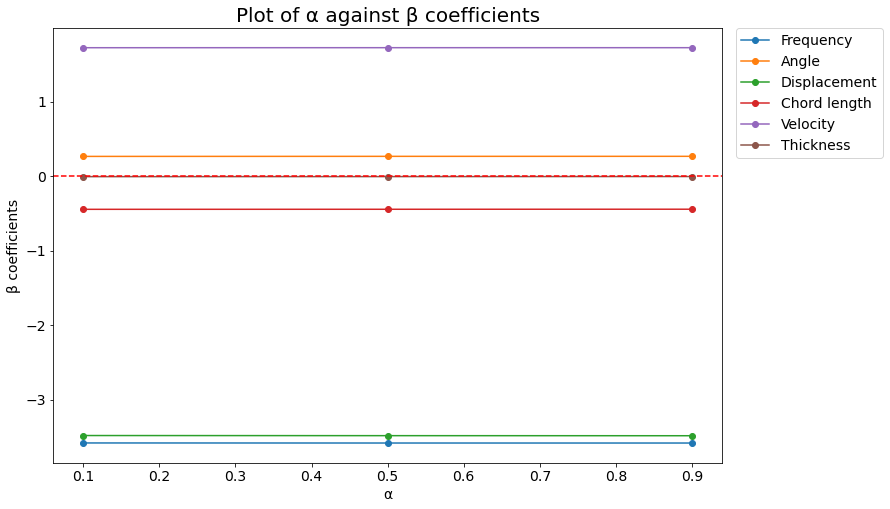

In [47]:
fig, ax = plt.subplots(figsize=(12,8))
beta_list = [beta01["beta"], beta05["beta"], beta09["beta"]]
for i in range(X_a_train.shape[1]):
    plt.plot([0.1, 0.5, 0.9], [coef[i] for coef in beta_list], label="{}".format(column_names[i]), marker='o')
plt.axhline(y=0, color='r', linestyle='dashed')
plt.xlabel("α", fontsize=14)
plt.ylabel("β coefficients", fontsize=14)
plt.title("Plot of α against β coefficients", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=14)
plt.show()

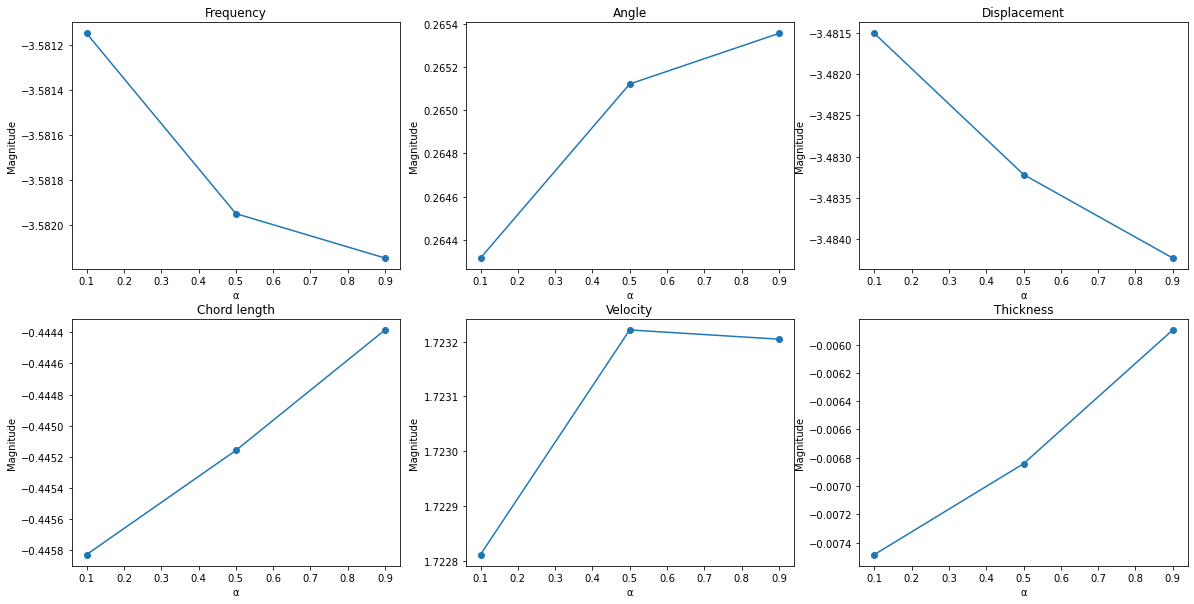

In [203]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.plot([0.1, 0.5, 0.9], [coef[0] for coef in beta_list], marker='o')
plt.title("{}".format(column_names[0]))
plt.xlabel("α")
plt.ylabel("Magnitude")

plt.subplot(2, 3, 2)
plt.plot([0.1, 0.5, 0.9], [coef[1] for coef in beta_list], marker='o')
plt.title("{}".format(column_names[1]))
plt.xlabel("α")
plt.ylabel("Magnitude")


plt.subplot(2, 3, 3)
plt.plot([0.1, 0.5, 0.9], [coef[2] for coef in beta_list], marker='o')
plt.title("{}".format(column_names[2]))
plt.xlabel("α")
plt.ylabel("Magnitude")


plt.subplot(2, 3, 4)
plt.plot([0.1, 0.5, 0.9], [coef[3] for coef in beta_list], marker='o')
plt.title("{}".format(column_names[3]))
plt.xlabel("α")
plt.ylabel("Magnitude")


plt.subplot(2, 3, 5)
plt.plot([0.1, 0.5, 0.9], [coef[4] for coef in beta_list], marker='o')
plt.title("{}".format(column_names[4]))
plt.xlabel("α")
plt.ylabel("Magnitude")


plt.subplot(2, 3, 6)
plt.plot([0.1, 0.5, 0.9], [coef[5] for coef in beta_list], marker='o')
plt.title("{}".format(column_names[5]))
plt.xlabel("α")
plt.ylabel("Magnitude")


plt.show()

When $\alpha = 0$, the lost function of elastic net linear regression reduces to the lost function of Ridge linear regression. It shrinks together the coefficients of correlated predictors towards zero. <br>
When $\alpha = 0.5$, the lost function places equal weight on the Lasso penalty and Ridge penalty. Thus, it is a compromise between Lasso and Ridge linear regression. The second term of the penalty encourages highly correlated features to be averaged, while the first term encourages a sparse solution in the coefficients of these averaged features. By applying a balanced combination of L1 and L2 regularisation, a model that is both sparse and well-fit can be created. <br>
When $\alpha = 1$, the lost function of elastic net linear regression reduces to the lost function of Lasso linear regression. It shrinks the coefficients of the predictors that are insignificant or highly correlated to other predictors to zero. Thus, it can perform continuous subset selection.

## kNN regression

We define the function `euclidean_distance` which will be compute the distance between points using the formula:
$$
d(\boldsymbol p, \boldsymbol q) = \sqrt{\sum_{i=1}^D{(q_i-p_i)^2}} \, ,
$$
where $\boldsymbol p$ and $\boldsymbol q$ are the two points in our $D$-dimensional Euclidean space.

In [204]:
def euclidean_distance(p, q):
    return np.sqrt(np.sum((p-q)**2, axis=1))

We define the function `k_neighbours` which computes all distances between inputs from the test set and the samples in the training dataset, then finds the k nearest neighbours for each input from the test set.

In [205]:
def k_neighbours(X_train, X_test, k, return_distance=False):
    n_neighbours = k
    dist = []
    neigh_ind = []

    # compute distance from each point x_test in X_test to all points in X_train
    point_dist = [euclidean_distance(x_test, X_train) for x_test in X_test]

    # determine which k training points are closest to each test point
    for row in point_dist:
        enum_neigh = enumerate(row)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

        ind_list = [tup[0] for tup in sorted_neigh]
        dist_list = [tup[1] for tup in sorted_neigh]

        dist.append(dist_list)
        neigh_ind.append(ind_list)

    # return distances together with indices of k nearest neighbours
    if return_distance:
        return np.array(dist), np.array(neigh_ind)

    return np.array(neigh_ind)

We define the function `reg_predict` which predicts the outputs of the test set by averaging over the values of the outputs of the training set in the neighbourhood.

In [206]:
def reg_predict(X_train, y_train, X_test, k):
    # each of the k neighbours contributes equally to the classification of any data point in X_test  
    neighbours = k_neighbours(X_train, X_test, k)
    # compute mean over neighbours labels
    y_pred = np.array([np.mean(y_train[neighbour]) for neighbour in neighbours])

    return y_pred

The function `cross_val_evaluate_kNN` implements T-fold cross validation and returns the MSE for the training dataset and validation set at each training/validation split.

In [207]:
def cross_val_evaluate_kNN(X, y, num_folds, k):
    folds = cross_val_split_np(X.shape[0], num_folds)

    train_scores = []
    val_scores = []
  
    for i in range(len(folds)):

        val_indices = folds[i]
        train_indices = list(set(range(X.shape[0])) - set(val_indices))
        
        # define the training set
        X_train = X[train_indices, :] 
        y_train = y[train_indices]
    
        # define the validation set
        X_val = X[val_indices, :]  
        y_val = y[val_indices]
        
        # standardise X
        X_train_z = standardise_train(X_train)
        X_val_z = standardise_test(X_train, X_val)

        # train the model and predict the y values for training and validation set
        y_pred_train = reg_predict(X_train_z, y_train, X_train_z, k)
        y_pred_val = reg_predict(X_train_z, y_train, X_val_z, k)

        # evaluate the scores of the training and validation set
        train_score = MSE(y_pred_train, y_train)
        val_score = MSE(y_pred_val, y_val)
        
        # store the training scores and validation scores
        train_scores.append(train_score)
        val_scores.append(val_score)

    return train_scores, val_scores

The function `choose_best_k` loops through the list of k values to find the penalty which gives the lowest average MSE for the validation set.

In [208]:
def choose_best_k(X, y, num_folds, k_list):
    best_k = k_list[0]
    best_mean_val = float('inf')
    mean_train_list =[]
    mean_val_list = []
    for k in k_list:
        # compute MSE for each training/validation split
        train_scores, val_scores = cross_val_evaluate_kNN(X, y, num_folds, k)
        
        # compute average MSE
        mean_train = np.mean(train_scores)
        mean_val = np.mean(val_scores)
        # print("k = {}: mean training MSE is {}, mean validation MSE is {}".format(k, mean_train, mean_val))
        
        # store the average MSE for training and validation set
        mean_train_list.append(mean_train)
        mean_val_list.append(mean_val)
        
        # update best k and lowest average MSE for validation set
        if mean_val < best_mean_val:
            best_k = k
            best_mean_val = mean_val
    return best_k, best_mean_val, mean_train_list, mean_val_list

We now employ a 5-fold cross validation to find the optimal value of the hyperparameter k.

In [209]:
k_list = np.arange(1, 21, 1)
best_k, best_mean_val, mean_train_list, mean_val_list = choose_best_k(X_a_train.to_numpy(), y_a_train.to_numpy(), 5, k_list)

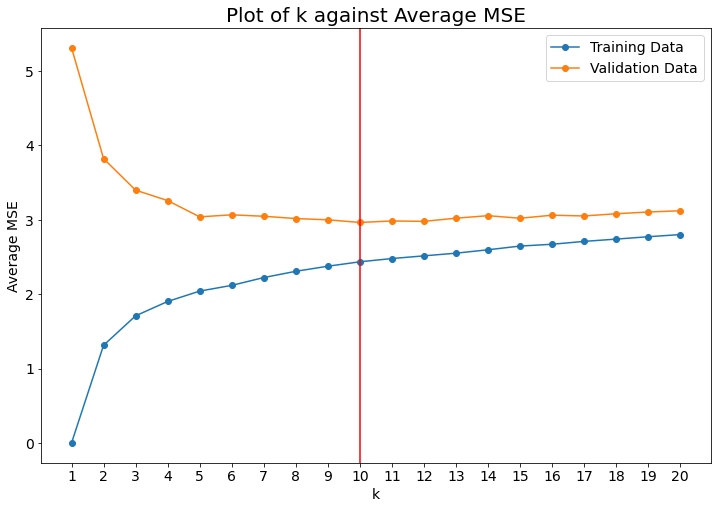

In [210]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(k_list, mean_train_list, label="Training Data", marker ='o')
plt.plot(k_list, mean_val_list, label="Validation Data", marker='o')
plt.axvline(x = best_k, color = 'r')
plt.xlabel("k", fontsize=14)
plt.ylabel("Average MSE", fontsize=14)
plt.title("Plot of k against Average MSE", fontsize=20)
plt.xticks(range(1, 21), size=14)
plt.yticks(size=14)
ax.legend(loc="best",fontsize=14)
plt.show()

In [211]:
print("The optimal value of k is {}".format(best_k))

The optimal value of k is 10


We will now retrain the model on the entire training dataset using the optimal k found above.

In [212]:
# training
y_pred = reg_predict(X_a_train_s.to_numpy(), y_a_train.to_numpy(), X_a_train_s.to_numpy(), best_k)
MSE_train_kNN = MSE(y_a_train.to_numpy(), y_pred)
r2_train_kNN = r2_score(y_a_train.to_numpy(), y_pred)

In [213]:
# test
y_pred = reg_predict(X_a_train_s.to_numpy(), y_a_train.to_numpy(), X_a_test_s.to_numpy(), best_k)
MSE_test_kNN = MSE(y_a_test.to_numpy(), y_pred)
r2_test_kNN = r2_score(y_a_test.to_numpy(), y_pred)

In [214]:
# Table of kNN scores
data_kNN = {'MSE': [MSE_train_kNN, MSE_test_kNN], 'R2 score': [r2_train_kNN, r2_test_kNN]}
df_kNN = pd.DataFrame(data_lasso, index=['Training', 'Test'])
df_kNN = df_kNN.style.set_properties(**{'font-size': '14pt'})
df_kNN = df_kNN.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_kNN

,MSE,R2 score
Training,1.918305,0.915859
Test,2.072284,0.904256


In [215]:
# Table of scores for each method in Task 1
data_1 = {'MSE': [MSE_test_lr, MSE_test_lasso, MSE_test_en_09, MSE_test_kNN], 
          'R2 score': [r2_test_lr, r2_test_lasso, r2_test_en_09, r2_test_kNN]}
df_1 = pd.DataFrame(data_1, index=['Linear Regression', 'Lasso Regression', 'Elastic Net Regression (α=0.9)', 'k-Nearest Neighbour'])
df_1 = df_1.style.set_properties(**{'font-size': '14pt'})
df_1 = df_1.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_1

,MSE,R2 score
Linear Regression,1.984390,0.908317
Lasso Regression,2.072284,0.904256
Elastic Net Regression (α=0.9),2.107181,0.902644
k-Nearest Neighbour,2.985675,0.862056


From the table above, linear regression outperforms all the other models as it has the lowest average MSE and highest avergae $R^{2}$ score. This implies that the underlying relationship between the predictors and outcomes is linear.

## Task 2: Classification  (50 marks)



#### 2.1 Random forest (20 marks)
2.1.1

We first load the training dataset *diabetes_samples.csv* and test dataset *diabetes_test.csv* into pandas data frames. 

In [298]:
diabetes_train = pd.read_csv("diabetes_samples.csv")
diabetes_test = pd.read_csv("diabetes_test.csv")

We print the first few rows of the dataset and view the summary statistics of the dataset to inspect the dataset.

In [299]:
diabetes_train.head()

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
0,115,224,85,30,"7,5",36,69,205,"30,3",150,99,37,41,"0,9",No diabetes
1,318,194,95,36,"5,4",63,58,210,"43,9",140,100,44,53,"0,83",No diabetes
2,73,207,75,44,"4,7",30,72,180,"24,4",118,62,35,41,"0,85",No diabetes
3,69,144,81,28,"5,1",30,72,165,"22,4",118,78,31,38,"0,82",No diabetes
4,326,181,177,24,"7,5",64,71,225,"31,4",130,66,44,47,"0,94",Diabetes


In [300]:
diabetes_train.describe()

,patient_number,cholesterol,glucose,hdl_chol,age,height,weight,systolic_bp,diastolic_bp,waist,hip
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,199.695971,208.868132,108.864469,50.531136,47.622711,66.032967,177.424908,136.772894,82.553114,37.941392,43.102564
std,115.880545,45.051737,55.762363,17.041255,17.110598,3.867618,40.460071,22.621073,13.161257,5.744903,5.834459
min,1.000000,78.000000,52.000000,12.000000,19.000000,55.000000,99.000000,98.000000,50.000000,26.000000,32.000000
25%,96.000000,179.000000,81.000000,39.000000,34.000000,63.000000,151.000000,121.000000,74.000000,33.000000,39.000000
50%,198.000000,204.000000,90.000000,46.000000,45.000000,66.000000,174.000000,136.000000,82.000000,37.000000,42.000000
75%,306.000000,232.000000,108.000000,59.000000,61.000000,69.000000,200.000000,148.000000,90.000000,42.000000,46.000000
max,390.000000,404.000000,385.000000,120.000000,92.000000,76.000000,308.000000,250.000000,118.000000,53.000000,64.000000


We set the index of the dataframe as *patient_number*.

In [301]:
diabetes_train = diabetes_train.set_index(diabetes_train['patient_number']).drop(diabetes_train.columns[0], axis=1)

For the columns *chol_hdl_ratio*, *bmi* and *waist_hip_ratio*, we will replace the `,` sign with `.`.

In [302]:
for column_name in ['chol_hdl_ratio', 'bmi', 'waist_hip_ratio']: 
    diabetes_train[column_name] = diabetes_train[column_name].str.replace(',', '.').astype(float)

For the target variable *diabetes*, we will replace the category `No diabetes` with `0` and the category `Diabetes` with `1`.

In [303]:
diabetes_train['diabetes'] = pd.factorize(diabetes_train['diabetes'])[0]

The dataset does not have any missing values and now seems cleaned.

In [304]:
diabetes_train.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
patient_number,,,,,,,,,,,,,,
115,224,85,30,7.5,36,69,205,30.3,150,99,37,41,0.90,0
318,194,95,36,5.4,63,58,210,43.9,140,100,44,53,0.83,0
73,207,75,44,4.7,30,72,180,24.4,118,62,35,41,0.85,0
69,144,81,28,5.1,30,72,165,22.4,118,78,31,38,0.82,0
326,181,177,24,7.5,64,71,225,31.4,130,66,44,47,0.94,1


We will apply the same data transformations onto the test dataset.

In [305]:
diabetes_test = diabetes_test.set_index(diabetes_test['patient_number']).drop(diabetes_test.columns[0], axis=1)

for column_name in ['chol_hdl_ratio', 'bmi', 'waist_hip_ratio']: 
    diabetes_test[column_name] = diabetes_test[column_name].str.replace(',', '.').astype(float)
    
diabetes_test['diabetes'] = pd.factorize(diabetes_test['diabetes'])[0]

We now split the training dataset into predictor set `X_d_train` and target `y_d_train`. We will also split the test dataset into predictor set `X_d_test` and target `y_d_test`.

In [306]:
X_d_train = diabetes_train.iloc[:,:-1]
y_d_train = diabetes_train.iloc[:,-1]
X_d_test = diabetes_test.iloc[:,:-1]
y_d_test = diabetes_test.iloc[:,-1]

`training_weights` assigns equal weights to each observation. <br>
`columns_dict` is a dictionary indicating whether the column index maps to a categorical feature or numerical. In this dataset, all the features are numerical so categorical=False for all columns.

In [307]:
training_weights = np.ones_like(y_d_train) / len(y_d_train)
columns_dict = {index: False for index in range(X_d_train.shape[1])}

The function `cross_entropy` computes cross entropy using the formula:
$$CE[\pi(R_{\alpha})]=\sum_{q=1}^{Q}{\pi_{q}(R_{\alpha})\log\pi_{q}(R_{\alpha})}$$
where $\pi_{q}(R_{\alpha})$ is the probability of being in given region $R_{\alpha}$ and belonging to a particular class $c_{q}$.

In [308]:
def cross_entropy(y, sample_weights):
    """ 
    Calculate the cross entropy for labels.
    Arguments:
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
    Returns:
        (float): the cross entropy for y.
    """

    # count different labels in y，and store in label_weights
    # initialize with zero for each distinct label.
    label_weights = {yi: 0 for yi in set(y)}  
    for yi, wi in zip(y, sample_weights):
        label_weights[yi] += wi

    total_weight = sum(label_weights.values())
    CE = 0
    for label, weight in label_weights.items():
        CE -= (weight / total_weight) * np.log(weight / total_weight)

    return CE

The function`split_samples` splits the data samples based on a column index and a value.

In [309]:
def split_samples(X, y, sample_weights, column, value, categorical):
    """
    Return the split of data whose column-th feature:
        1. equals value, in case `column` is categorical, or
        2. less than value, in case `column` is not categorical (i.e. numerical)

    Arguments:
        X: training features, of shape (N, D).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        column: the column of the feature for splitting.
        value: splitting threshold  the samples 
        categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        tuple(np.array, np.array): tuple of subsets of X splitted based on column-th value.
        tuple(np.array, np.array): tuple of subsets of y splitted based on column-th value.
        tuple(np.array, np.array): tuple of subsets of sample weights based on column-th value.
    """ 

    if categorical:
        left_mask =(X[:, column] == value)
    else:
        left_mask = (X[:, column] < value)
  
    X_left, X_right = X[left_mask, :], X[~left_mask, :]
    y_left, y_right = y[left_mask], y[~left_mask]
    w_left, w_right  = sample_weights[left_mask], sample_weights[~left_mask]

    return (X_left, X_right), (y_left, y_right), (w_left, w_right)

The function `cross_entropy_split_value` searches for the threshold that minimises the cross entropy.

In [310]:
def cross_entropy_split_value(X, y, sample_weights, column, categorical):
    """
    Calculate the cross entropy based on `column` with the split that minimizes the cross entropy.
    Arguments:
        X: training features, of shape (N, D).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        column: the column of the feature for calculating. 0 <= column < D
        categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        (float, float): the resulted cross entropy and the corresponding value used in splitting.
    """
  
    unique_vals = np.unique(X[:, column])

    assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

    cross_entropy_val, threshold = np.inf, None
  
    # split the values of i-th feature and calculate the cost 
    for value in unique_vals:
        (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, column, value, categorical)

        # if one of the two sides is empty, skip this split.
        if len(y_l) == 0 or len(y_r) == 0:
            continue
    
        p_left = sum(w_l)/(sum(w_l) + sum(w_r))
        p_right = 1 - p_left
        new_cost = p_left * cross_entropy(y_l, w_l) + p_right * cross_entropy(y_r, w_r)
        if new_cost < cross_entropy_val:
            cross_entropy_val, threshold = new_cost, value
    
    return cross_entropy_val, threshold

The function `cross_entropy_split_rf` implements feature bagging and then finds the best split column and split value which minimises the cross entropy.

In [311]:
def cross_entropy_split_rf(n_features, X, y, sample_weights, columns_dict):
    """
    Choose the best feature to split according to criterion.
    Arguments:
        n_features: number of sampled features.
        X: training features, of shape (N, D).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        (float, int, float): the minimized cross entropy, the best feature index and value used in splitting.
    """
    # feature bagging
    columns = np.random.choice(list(columns_dict.keys()), n_features, replace=False)
    columns_dict = {c: columns_dict[c] for c in columns}

    min_cross_entropy, split_column, split_val = np.inf, 0, 0
    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue

        # search for the best splitting value for the given column.
        cross_entropy, val = cross_entropy_split_value(X, y, sample_weights, column, categorical)     
        if cross_entropy < min_cross_entropy:
            min_cross_entropy, split_column, split_val = cross_entropy, column, val

    return min_cross_entropy, split_column, split_val

The function `majority_vote` returns a dictionary containing the probabilities of a label being 0 and 1.

In [312]:
def majority_vote(y, sample_weights):
    """
    Arguments:
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
    Returns:
        prob: a dictionary containing the probabilities of a label being 0 and 1
    """
    majority_label = {yi: 0 for yi in set(y)}

    for yi, wi in zip(y, sample_weights):
        majority_label[yi] += wi
    
    total_weight = sum(majority_label.values())
    if 1 in majority_label.keys():
        class1 = majority_label[1]
    else:
        class1 = 0
    prob1 = class1 / total_weight
    prob0 = 1 - prob1
    
    # EDIT
    prob = {0: prob0, 1: prob1}
    return prob

The function `build_tree_rf` builds the decision tree according to the data.

In [313]:
def build_tree_rf(n_features, X, y, sample_weights, columns_dict, feature_names, max_depth, depth, min_samples_leaf=1):
    """Build the decision tree according to the data.
    Arguments:
        n_features: number of predictors taken into consideration randomly at each split.
        X: (np.array) training features, of shape (N, D).
        y: (np.array) vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): record the name of features in X in the original dataset.
        max_depth: maximum depth of trees.
        depth (int): current depth for this node.
        min_sample_leaf: minimum number of instances at a leaf.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
            1. 'feature_name': The column name of the split.
            2. 'feature_index': The column index of the split.
            3. 'value': The value used for the split.
            4. 'categorical': indicator for categorical/numerical variables.
            5. 'prob': For leaf nodes, this stores the probability of a label being 0 and 1. Otherwise, it is None.
            6. 'left': The left sub-tree with the same structure.
            7. 'right' The right sub-tree with the same structure.
    """
    # include a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
    if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf: 
        return {'prob': majority_vote(y, sample_weights)}
  
    else:
        CE, split_index, split_val = cross_entropy_split_rf(n_features, X, y, sample_weights, columns_dict)
    
        # If CE is infinity, it means that samples are not seperable by the sampled features.
        if CE == np.inf:
            return {'prob': majority_vote(y, sample_weights)}
        categorical = columns_dict[split_index]
        (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, split_index, split_val, categorical)
        return {
            'feature_name': feature_names[split_index],
            'feature_index': split_index,
            'value': split_val,
            'categorical': categorical,
            'prob': None,
            'left': build_tree_rf(n_features, X_l, y_l, w_l, columns_dict, feature_names, max_depth, depth + 1, min_samples_leaf),
            'right': build_tree_rf(n_features, X_r, y_r, w_r, columns_dict, feature_names, max_depth, depth + 1, min_samples_leaf) 
        }

The function `train_rf` builds the random forest model according to the training data.

In [314]:
def train_rf(B, n_features, max_depth, X, y, columns_dict, sample_weights=None):
    """
    Build the random forest model according to the training data.
    Args:
        B: number of decision trees.
        n_features: number of predictors taken into consideration randomly at each split.
        max_depth: maximum depth of trees.
        X: (pd.Dataframe) training features, of shape (N, D). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        sample_weights: weights for each samples, of shape (N,).
    """
    if sample_weights is None:
        # if the sample weights is not provided, we assume the samples have uniform weights
        sample_weights = np.ones(X.shape[0]) / X.shape[0]
    else:
        sample_weights = np.array(sample_weights) / np.sum(sample_weights)

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []

    for _ in range(B):
        sample = np.random.choice(training_indices, N, replace=True)
        X_sample = X[sample, :]
        y_sample = y[sample]
        w_sample = sample_weights[sample]
        tree = build_tree_rf(n_features, X_sample, y_sample, w_sample, columns_dict, feature_names, max_depth, depth=1)
        trees.append(tree)

    return trees

The function `classify` takes each single data point `x` as an argument and returns the dictionary containing the probabilities of the label being 0 and 1.

In [315]:
def classify(tree, x):
    """
    Classify a single sample with the fitted decision tree.
    Args:
        x: ((pd.Dataframe) a single sample features, of shape (D,).
    Returns:
        prob: a dictionary containing the probabilities of a label being 0 and 1
    """
    
    if tree['prob'] is not None: 
        return tree['prob']

    elif tree['categorical']:
        if x[tree['feature_index']] == tree['value']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'], x)

    else:
        if x[tree['feature_index']] < tree['value']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'], x)

The function `predict_rf` function aggregates the probabilities from all decision trees and returns the class based on the threshold provided.

In [316]:
def predict_rf(rf, X, B, roc_threshold):
    """
    Predict classification results for X.
    Args:
        rf: A trained random forest through train_rf function.
        X: (pd.Dataframe) testing sample features, of shape (N, D).
        roc_threshold: threshold probability for a label to be classified as 1.
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """

    def aggregate(decisions):
        count = defaultdict(int)
        for decision in decisions:
            count[0] += decision[0]
            count[1] += decision[1]
        prob0 = count[0] / B
        prob1 = count[1] / B
        if prob1 >= roc_threshold:
            return 1
        else:
            return 0

    if len(X.shape) == 1:
        return aggregate([classify(tree, X) for tree in rf])
    else:
        return np.array([aggregate([classify(tree, x) for tree in rf]) for x in X])

The function `rf_accuracy` computes accuracy using the formula:
$$\text{accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$
where TP is the number of true positives, TN is the number of true negatives, FP is the number of false positives and FN is the number of false negatives.

In [317]:
# accuracy
def rf_accuracy(rf, X_test, y_test, B, roc_threshold):
    y_pred = predict_rf(rf, X_test, B, roc_threshold)
    return np.mean(y_pred==y_test)

In [318]:
def cross_val_split_pd(X, num_folds):
    N = X.shape[0]
    fold_size = N // num_folds
    index_perm = np.random.permutation(X.index)
    folds = []
    for k in range(num_folds):
        folds.append(index_perm[k*fold_size:(k+1)*fold_size])
    return folds

The function `cross_val_evaluate_rf` implements T-fold cross validation and returns the accuracy for the training dataset and validation set at each training/validation split.

In [319]:
def cross_val_evaluate_rf(X, y, num_folds, B, max_depth, sample_weights, roc_threshold):
    """
    Arguments:
        X: data of size (n, d)
        y: true label vector of size (n, 1)
        num_folds: number of folds for cross-validation
        B: number of decision trees
        max_depth: maximum depth of trees
        sample_weights:  weights for each samples, of shape (N,)
        roc_threshold: threshold probability for a label to be classified as 1
    Returns:
        train_scores: list of training scores for each training/validation split
        val_scores: list of validation scores for each training/validation split
    """
    folds = cross_val_split_pd(X, num_folds)
    # number of features for feature bagging is set to be square root of the number of predictors
    n_features = int(np.sqrt(X.shape[1]))

    train_scores = []
    val_scores = []
  
    for i in range(len(folds)):

        val_indices = folds[i]
        train_indices = list(set(set(X.index) - set(val_indices)))
        
        # define the training set
        X_train = X.loc[train_indices,:] 
        y_train = y[train_indices]
    
        # define the validation set
        X_val = X.loc[val_indices,:]  
        y_val = y[val_indices] 

        # train the model
        rf = train_rf(B, n_features, max_depth, X_train, y_train, columns_dict, sample_weights)

        # evaluate the scores of the training and validation set
        train_score = rf_accuracy(rf, X_train.to_numpy(), y_train.to_numpy(), B, roc_threshold)
        val_score = rf_accuracy(rf, X_val.to_numpy(), y_val.to_numpy(), B, roc_threshold)
        
        # store the training scores and validation scores
        train_scores.append(train_score)
        val_scores.append(val_score)

    return train_scores, val_scores

The function `grid_search_rf` loops through the list of B values and max_depth values pairwise to find the number of decision trees and maximum depth of decision trees which gives the highest average accuracy for the validation set.

In [320]:
def grid_search_rf(X, y, num_folds, hyperparameters, sample_weights, roc_threshold):
    """
    Performs grid search over hyperparameters.
    Arguments:
        X: data of size (n, d)
        y: true label vector of size (n, 1)
        num_folds: number of folds for cross-validation
        hyperparameters: a dictionary containing list of hyperparameters (B and max_depth)
        sample_weights:  weights for each samples, of shape (N,)
        roc_threshold: threshold probability for a label to be classified as 1
    Returns:
        best_B: B which gives the highest average accuracy for the validation set when paired with best_max_depth
        best_max_depth: max_depth which gives the highest average accuracy for the validation set when paired with best_B
        best_mean_val: highest average accuracy for the validation set
    """
    B_list = hyperparameters["B"]
    max_depth_list = hyperparameters["max_depth"]
    best_B = B_list[0]
    best_max_depth = max_depth_list[0]
    best_mean_val = 0
    mean_val_list = []
    for B in B_list:
        for max_depth in max_depth_list:
            # compute accuracy for each training/validation split
            train_scores, val_scores = cross_val_evaluate_rf(X, y, num_folds, B, max_depth, sample_weights, roc_threshold)
            
            # compute average accuracy
            mean_train = np.mean(train_scores)
            mean_val = np.mean(val_scores)
            # print("B = {}, max_depth = {}: mean training accuracy is {}, mean validation accuracy is {}".format(B, max_depth, mean_train, mean_val))
            mean_val_list.append(mean_val)
            
            # update best B, best max_depth and highest average accuracy for validation set
            if mean_val > best_mean_val:
                best_B = B
                best_max_depth = max_depth
                best_mean_val = mean_val
    return best_B, best_max_depth, best_mean_val, mean_val_list

We now employ a 4-fold cross validation to tune the the number of decision trees, B and the maximum depth of decision trees, max_depth.

In [321]:
hyperparameters = {"B": [40, 50, 60, 70, 80], "max_depth": [5, 6, 7, 8, 9]}
best_B, best_max_depth, best_mean_val, mean_val_list = grid_search_rf(X_d_train, y_d_train, 4, hyperparameters, training_weights, 0.5)

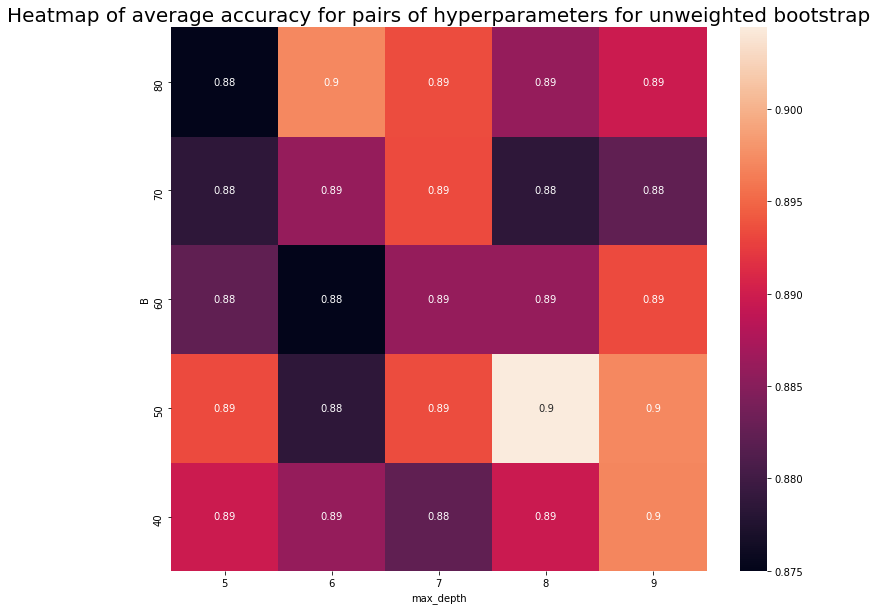

In [322]:
# Heatmap of average accuracy for pairs of hyperparameters for unweighted bootstrap
combination_list = [p for p in product(hyperparameters["B"], hyperparameters["max_depth"])]
df_h_uw = pd.DataFrame(combination_list, columns=["B","max_depth"])
df_h_uw["Average Accuracy"] = mean_val_list
df_h_uw = df_h_uw.pivot("B", "max_depth", "Average Accuracy")
fig, ax = plt.subplots(figsize=(12,10)) 
sns.heatmap(df_h_uw, annot=True)
plt.title("Heatmap of average accuracy for pairs of hyperparameters for unweighted bootstrap", fontsize=20)
ax.invert_yaxis()

In [323]:
print("The optimal value of B is {} and optimal value of max_depth is {}".format(best_B, best_max_depth))

The optimal value of B is 50 and optimal value of max_depth is 8


2.1.2

We will now retrain the model on the entire training dataset using the optimal B and max_depth found above.

In [324]:
n_features = int(np.sqrt(X_d_train.shape[1]))
best_rf = train_rf(best_B, n_features, best_max_depth, X_d_train, y_d_train, columns_dict, training_weights)

The function `rf_scores` computes the the following quality measures:
1. $\text{precision}=\frac{TP}{TP + FP}$
2. $\text{F-score}=2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}$
3. $\text{recall} = \frac{TP}{TP + FN}$
4. $\text{false positive rate} = \frac{FP}{TN + FP}$

In [325]:
# precision, F-score, recall, fpr
def rf_scores(rf, X_test, y_test, B, roc_threshold):
    y_pred = predict_rf(rf, X_test, B, roc_threshold)
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(y_test)):
        if y_pred[i] == y_test[i] == 1:
            TP +=1
        elif y_pred[i] == 1 and y_test[i] == 0:
            FP +=1
        elif y_pred[i] == 0 and y_test[i] == 1:
            FN += 1
        else:
            TN += 1
    recall = TP / (TP + FN)
    fpr = FP / (TN + FP) 
    if (TP + FP) == 0:
        precision = None
        F_score = None
    else:
        precision = TP / (TP + FP)
        F_score = 2 * precision * recall / (precision + recall)
    return precision, F_score, recall, fpr

In [326]:
# Compute accuracy, precision and F-score
acc_train = rf_accuracy(best_rf, X_d_train.to_numpy(), y_d_train.to_numpy(), best_B, 0.5)
acc_test = rf_accuracy(best_rf, X_d_test.to_numpy(), y_d_test.to_numpy(), best_B, 0.5)
scores_train = rf_scores(best_rf, X_d_train.to_numpy(), y_d_train.to_numpy(), best_B, 0.5)
scores_test = rf_scores(best_rf, X_d_test.to_numpy(), y_d_test.to_numpy(), best_B, 0.5)

In [327]:
# Table of unweighted random forest scores
data_rf = {'Accuracy': [acc_train, acc_test], 'Precision': [scores_train[0], scores_test[0]], 'F-score':[scores_train[1], scores_test[1]]}
df_rf = pd.DataFrame(data_rf, index=['Training', 'Test'])
df_rf = df_rf.style.set_properties(**{'font-size': '14pt'})
df_rf = df_rf.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_rf

,Accuracy,Precision,F-score
Training,0.996337,1.000000,0.988506
Test,0.931624,0.833333,0.714286


From the table above, we observe that the precision and F-score on the test set is relatively low compared to the accuracy on the test set. This implies that the dataset might be imbalanced, where the high accuracy is due to the fact that the majority class only is well predicted, whereas the low precision and F-score conveys that the minority class is not well predicted.

2.1.3

In [339]:
freq_0 = np.sum(y_d_train == 0)
freq_1 = np.sum(y_d_train == 1)
print("Frequency of No Diabetes outcomes is {}".format(freq_0))
print("Frequency of Diabetes outcomes is {}".format(freq_1))

Frequency of No Diabetes outcomes is 229
Frequency of Diabetes outcomes is 44


We observe that the frequency of No Diabetes outcome is much higher than the frequency of Diabetes outcome, thus the dataset *diabetets_samples.csv* is unbalanced. We introduce weights that are inversely proportional to the frequency of each outcome so that No Diabetes outcome will have less weight and Diabetes outcome will have higher weight to balance the diagnosis outcomes.

In [340]:
# inverse of number of samples
training_weights_balanced = np.zeros(len(y_d_train))
for i in range(len(y_d_train)):
    if y_d_train.to_numpy()[i] == 1:
        training_weights_balanced[i] = 1 / freq_1
    else:
        training_weights_balanced[i] = 1 / freq_0

We now employ a 4-fold cross validation using the weighted samples to tune the the number of decision trees, B and the maximum depth of decision trees, max_depth.

In [341]:
best_B_balanced, best_max_depth_balanced, best_mean_val_balanced, mean_val_list_balanced = grid_search_rf(X_d_train, y_d_train, 4, hyperparameters, training_weights_balanced, 0.5)

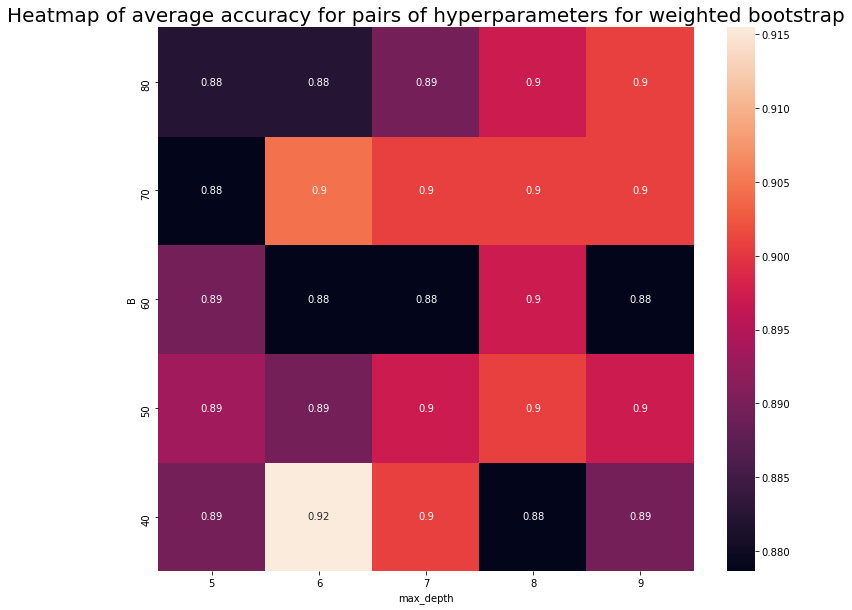

In [342]:
# Heatmap of average accuracy for pairs of hyperparameters for weighted bootstrap
df_h_w = pd.DataFrame(combination_list, columns=["B","max_depth"])
df_h_w["Average Accuracy"] = mean_val_list_balanced
df_h_w = df_h_w.pivot("B", "max_depth", "Average Accuracy")
fig, ax = plt.subplots(figsize=(12,10)) 
sns.heatmap(df_h_w, annot=True)
plt.title("Heatmap of average accuracy for pairs of hyperparameters for weighted bootstrap", fontsize=20)
ax.invert_yaxis()

In [343]:
print("For the weighted samples, the optimal value of B is {} and optimal value of max_depth is {}".format(best_B_balanced, best_max_depth_balanced))

For the weighted samples, the optimal value of B is 40 and optimal value of max_depth is 6


We will now retrain the model on the entire weighted training dataset using the optimal B and max_depth found above.

In [344]:
# Compute accuracy, preciison and F-score
best_rf_balanced = train_rf(best_B_balanced, n_features, best_max_depth_balanced, X_d_train, y_d_train, columns_dict, training_weights_balanced)
acc_train_balanced = rf_accuracy(best_rf_balanced, X_d_train.to_numpy(), y_d_train.to_numpy(), best_B_balanced, 0.5)
acc_test_balanced = rf_accuracy(best_rf_balanced, X_d_test.to_numpy(), y_d_test.to_numpy(), best_B_balanced, 0.5)
scores_train_balanced = rf_scores(best_rf_balanced, X_d_train.to_numpy(), y_d_train.to_numpy(), best_B_balanced, 0.5)
scores_test_balanced = rf_scores(best_rf_balanced, X_d_test.to_numpy(), y_d_test.to_numpy(), best_B_balanced, 0.5)

In [345]:
# Table of weighted random forest scores
data_rf_w = {'Accuracy': [acc_train_balanced, acc_test_balanced], 'Precision': [scores_train_balanced[0], scores_test_balanced[0]], 'F-score':[scores_train_balanced[1], scores_test_balanced[1]]}
df_rf_w = pd.DataFrame(data_rf_w, index=['Training', 'Test'])
df_rf_w = df_rf_w.style.set_properties(**{'font-size': '14pt'})
df_rf_w = df_rf_w.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_rf_w

,Accuracy,Precision,F-score
Training,0.963370,0.840000,0.893617
Test,0.923077,0.705882,0.727273


The function `curve` computes the quality measures required to plot roc curve and precision-recall curve for each threshold. It returns the area under each curve as well.

In [346]:
def curve(rf, X_test, y_test, B, roc_threshold_list):
    """
    Arguments:
        rf: random forest model
        X_test: data of size (n, d)
        y_test: true label vector of size (n, d)
        B: number of decision trees
        roc_threshold_list: list of thresholds sorted descendingly.
  
    Returns:
        auc: area under the curve (AUC).
        tpr_l: a list of true positive rate (TPR) values for each threshold.
        fpr_l: a list of false positive rate (FPR) values for each threshold.
    """
    tpr_l, fpr_l, precision_l = [], [], []
    count_list = []
    count = 0
    
    for roc_threshold in roc_threshold_list:
        # compute quality measures required to plot roc curve and precision-recall curve
        precision, F_score, tpr, fpr = rf_scores(rf, X_test, y_test, B, roc_threshold)
        tpr_l.append(tpr)
        fpr_l.append(fpr)
        if precision is not None:
            precision_l.append(precision)
            count_list.append(count)
        count += 1
        
    # Compute AUC using Trapezoidal rule
    auc_roc = np.trapz(tpr_l, fpr_l)
    tpr_l_r = [tpr_l[i] for i in count_list]
    auc_pr = np.trapz(precision_l, tpr_l_r)
    return auc_roc, auc_pr, tpr_l, tpr_l_r, fpr_l, precision_l

In [347]:
roc_threshold_list = np.flip(np.arange(0, 1.05, 0.05))
auc_roc, auc_pr, tpr, tpr_r, fpr, precision = curve(best_rf, X_d_test.to_numpy(), y_d_test.to_numpy(), best_B, roc_threshold_list)
auc_roc_balanced, auc_pr_balanced, tpr_balanced, tpr_r_balanced, fpr_balanced, precision_balanced = curve(best_rf_balanced, X_d_test.to_numpy(), y_d_test.to_numpy(), best_B_balanced, roc_threshold_list)

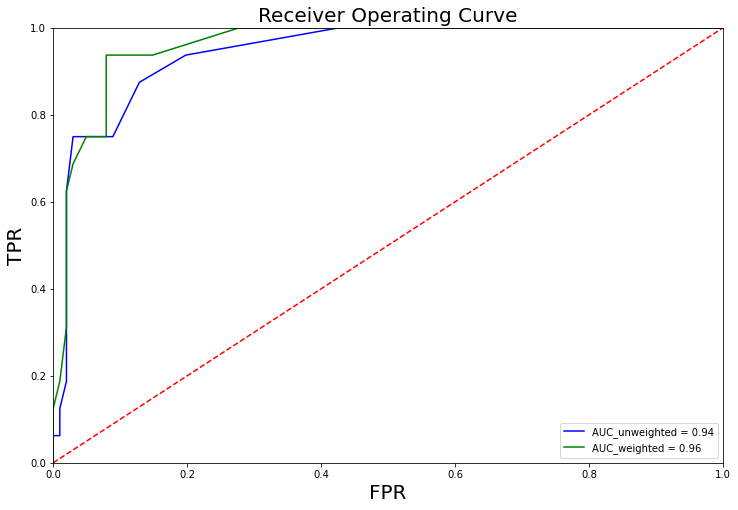

In [348]:
# ROC curve
plt.figure(figsize=(12,8))
plt.title(f"Receiver Operating Curve", size=20)
plt.plot(fpr, tpr, 'b', label = f'AUC_unweighted = {auc_roc:0.2f}')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR', size=20)
plt.xlabel('FPR', size=20)
plt.plot(fpr_balanced, tpr_balanced, 'g', label = f'AUC_weighted = {auc_roc_balanced:0.2f}')
plt.legend(loc = 'lower right')
plt.show()

According to the ROC curve, the AUC for the random forest classifier with weighted bootstrap is higher than the AUC of the random forest classifier with standard bootstrap. This implies the random forest classifier with weighted bootstrap has better discriminating ability than the random forest classfier with standard bootstrap.

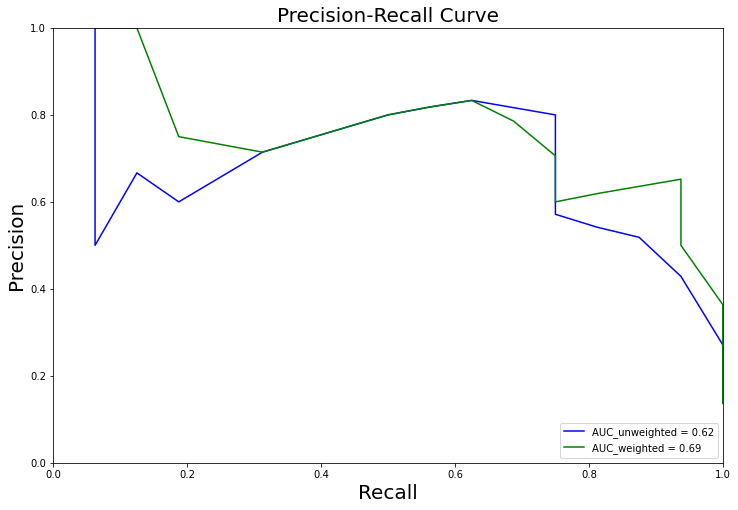

In [349]:
# Precision-Recall curve
plt.figure(figsize=(12,8))
plt.title(f"Precision-Recall Curve", size=20)
plt.plot(tpr_r, precision, 'b', label = f'AUC_unweighted = {auc_pr:0.2f}')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision', size=20)
plt.xlabel('Recall', size=20)
plt.plot(tpr_r_balanced, precision_balanced, 'g', label = f'AUC_weighted = {auc_pr_balanced:0.2f}')
plt.legend(loc = 'lower right')
plt.show()

According to the precision-recall curve, the AUC for the random forest classifier with weighted bootstrap is much higher than the AUC of the random forest classifier with standard bootstrap. This implies that the random forest classifier with weighted bootstrap is better at prediciting the minority class compared to the random forest classifier with standard bootstrap. This is also further affirmed by the fact that the F-score of the random forest classifier with weighted bootstrap is higher than the random forest classifier with standard bootstrap.

#### 2.2	Support Vector Machine (SVM) (30 marks)
2.2.1

For the target variable *diabetes*, we will replace the category `No diabetes` with `-1` and the category `Diabetes` with `1`.

In [350]:
# convert categorical labels to 1: Diabetes and -1: No Diabetes
y_d_train_svm = y_d_train.copy()
y_d_train_svm = y_d_train.map({0: -1.0, 1: 1.0})
y_d_test_svm = y_d_test.copy()
y_d_test_svm = y_d_test.map({0: -1.0, 1: 1.0})

We standardise `X_d_train` and `X_d_test` using the `standardise_train` and `standardise_test` functions defined above. We also insert a column of ones in the first column of each X to include the intercept b. We assign the processed training dataset to `X_d_train_svm` and the processed test dataset to `X_d_test_svm`.

In [351]:
# standardise X and insert 1 in every row for intercept b
X_d_train_s = standardise_train(X_d_train)
X_d_train_svm = np.hstack((X_d_train_s, np.ones((len(X_d_train_s),1))))
X_d_test_s = standardise_test(X_d_train, X_d_test)
X_d_test_svm = np.hstack((X_d_test_s, np.ones((len(X_d_test_s),1))))

We aim to minimise the loss function for the soft-margin linear SVM classifier:
$$
\mathcal L (\boldsymbol w) = \frac{1}{2} \| \boldsymbol w \|^2 + \lambda \sum_{i=1}^N \max \bigg( 0, 1-y^{(i)} (x^{(i)} \cdot \boldsymbol w  + b) \bigg) \, .
$$
where $\boldsymbol w$ is the vector of weights, $\lambda$ the regularisation parameter, and $b$ the intercept which is included in our `X` as an additional column of $1$'s. <br>
The `compute_cost` function computes the cost using the formula above.

In [352]:
def compute_cost(w, X, y, regul_strength):
    n = X.shape[0]
    distances = 1 - y * (X @ w)
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = regul_strength * np.sum(distances)

    # calculate cost
    return 0.5 * np.dot(w, w) + hinge -0.5*w[-1]**2

The function `calculate_cost_gradient` computes the gradients of the cost with respect to $\boldsymbol w$.

In [353]:
def calculate_cost_gradient(w, X_batch, y_batch, regul_strength):
    # if only one example is passed
    if type(y_batch) == np.float64:
        y_batch = np.asarray([y_batch])
        X_batch = np.asarray([X_batch])  # gives multidimensional array

    distance = 1 - (y_batch * (X_batch @ w))
    dw = np.zeros(len(w))

    we = w.copy() # So as not to overwrite w
    we[-1] = 0 # So as not to have b in its derivative when adding the weights in di
    
    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = we/len(y_batch) # derivative of first term
        else:
            di = we/len(y_batch) - (regul_strength * y_batch[ind] * X_batch[ind])
        dw += di

    return dw

The `sgd` function implements stochastic gradient descent to update the weights iteratively with learning rate $\alpha$ using the formula below:
$$
\boldsymbol w = \boldsymbol w - \alpha \frac{\partial \mathcal L}{\partial \boldsymbol w}
$$
A stop criterion is implemented so that the algorithm stops when the change in the cost function is not significant.

In [354]:
def sgd(X, y, max_iterations, stop_criterion, learning_rate, regul_strength, print_outcome=False):
  
    # initialise zero weights
    weights = np.zeros(X.shape[1])
    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf
  
    # stochastic gradient descent
    indices = np.arange(len(y))

    for iteration in range(1, max_iterations):
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]
    
        for xi, yi in zip(X, y):
            descent = calculate_cost_gradient(weights, xi, yi, regul_strength)
            weights = weights - (learning_rate * descent)

        # convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:
            # compute cost
            cost = compute_cost(weights, X, y, regul_strength)
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return weights
        
            prev_cost = cost
            nth += 1
  
    return weights

The function `svm_accuracy` computes the accuracy of the predicted values of y.

In [355]:
def svm_accuracy(w, X, y):
    y_preds = np.sign(X @ w)
    return np.mean(y == y_preds)

The function `cross_val_evaluate_svm` implements T-fold cross validation and returns the accuracy for the training dataset and validation set at each training/validation split.

In [356]:
def cross_val_evaluate_svm(X, y, num_folds, regul_strength):
    folds = cross_val_split_pd(X, num_folds)

    train_scores = []
    val_scores = []
  
    for i in range(len(folds)):

        val_indices = folds[i]
        train_indices = list(set(set(X.index) - set(val_indices)))
        
        # define the training set
        X_train = X.loc[train_indices, :] 
        y_train = y[train_indices]
    
        # define the validation set
        X_val = X.loc[val_indices, :]  
        y_val = y[val_indices]
        
        # standardise X
        X_train_z = standardise_train(X_train)
        X_val_z = standardise_test(X_train, X_val)
        
        # insert 1 in every row for intercept b
        X_train_z = np.hstack((X_train_z, np.ones((len(X_train_z),1))))
        X_val_z = np.hstack((X_val_z, np.ones((len(X_val_z),1)))) 
        
        y_train = y_train.to_numpy()
        y_val = y_val.to_numpy()

        # train the model
        w = sgd(X_train_z, y_train, max_iterations=10000, stop_criterion=0.0001, learning_rate=1e-6, regul_strength=regul_strength)

        # evaluate the scores of the training and validation set
        train_score = svm_accuracy(w, X_train_z, y_train)
        val_score = svm_accuracy(w, X_val_z, y_val)
        
        # store the training scores and validation scores
        train_scores.append(train_score)
        val_scores.append(val_score)

    return train_scores, val_scores

The function `find_best_lambda` loops through the list of $\lambda$ values to find the $\lambda$ which gives the highest average accuracy for the validation set.

In [357]:
def find_best_lambda(X, y, num_folds, regul_strength_list):
    best_lambda = regul_strength_list[0]
    best_mean_val = 0
    mean_train_list =[]
    mean_val_list = []
    for regul_strength in regul_strength_list:
        # compute accuracy for each training/validation split
        train_scores, val_scores = cross_val_evaluate_svm(X, y, num_folds, regul_strength)
        
        # compute average accuracy
        mean_train = np.mean(train_scores)
        mean_val = np.mean(val_scores)
        # print("λ = {}: mean training accuracy is {}, mean validation accuracy is {}".format(regul_strength, mean_train, mean_val))
        
        # store the average MSE for training and validation set
        mean_train_list.append(mean_train)
        mean_val_list.append(mean_val)
        
        # update best λ and highest average accuracy for validation set
        if mean_val > best_mean_val:
            best_lambda = regul_strength
            best_mean_val = mean_val
    return best_lambda, best_mean_val, mean_train_list, mean_val_list

We now employ a 4-fold cross validation to tune the hardness hyperparameter $\lambda$.

In [358]:
regul_strength_list = 10 ** np.arange(-3, 7, dtype=float)
best_lambda, best_mean_val, mean_train_list, mean_val_list = find_best_lambda(X_d_train, y_d_train_svm, 4, regul_strength_list)

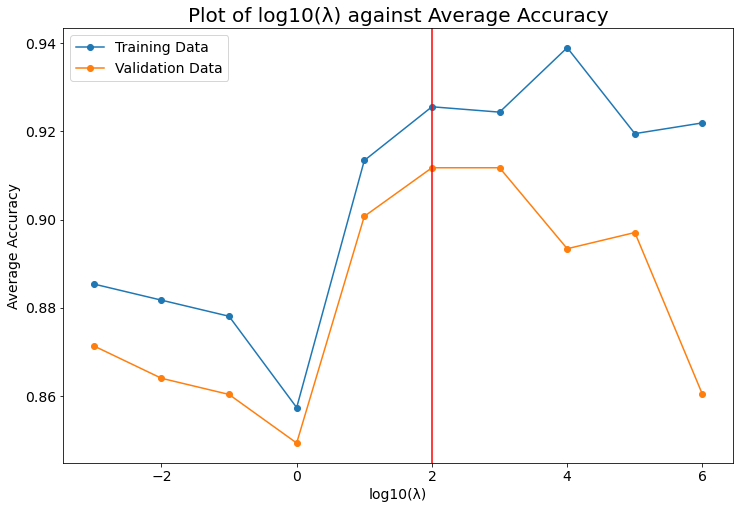

In [359]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(np.log10(regul_strength_list), mean_train_list, label="Training Data", marker='o')
plt.plot(np.log10(regul_strength_list), mean_val_list, label="Validation Data", marker='o')
plt.axvline(x=np.log10(best_lambda), color='r')
plt.xlabel("log10(λ)", fontsize=14)
plt.ylabel("Average Accuracy", fontsize=14)
plt.title("Plot of log10(λ) against Average Accuracy", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
ax.legend(loc="best",fontsize=14)
plt.show()

The average accuracy incrases as the hardness parameter $\lambda$ increases from $\log_{10}(\lambda)=0$ and reaches maximum at $\log_{10}(\lambda)=2$. After $\log_{10}(\lambda)=2$, the average accuracy gradually decreases. <br>
In the limit of small $\lambda$, i.e. low hardness, the model is less constrained by the regularisation and more flexible, resulting in a wider margin and more misclassifications. The variance increases and the bias decreases. If the $\lambda$ is too small, the model may become too complex, thus increasing the risk of overfitting.<br> 
In the limit of large $\lambda$, i.e. high hardness, this optimisation approcahes the hard-margin SVM, which requires the data points to be separable in d-dimensional space. This is infeasible when the separating hyperplane does not exist. The model is more constrained by the regularisation, resulting in a narrower margin and less misclassifications. The variance decreases and the bias increases. If the $\lambda$ is too large, the model may become too simple, thus increasing the risk of underfitting.

In [360]:
print("The optimal value of λ is {}".format(best_lambda))

The optimal value of λ is 100.0


2.2.2

We store the vectors normal to the hyperplane for each value of $\lambda$ in a list.

In [361]:
# list of vectors normal to hyperplane
w_list = [sgd(X_d_train_svm, y_d_train_svm.to_numpy(), max_iterations=10000, stop_criterion=0.001, learning_rate=1e-6, regul_strength=regul_strength) for regul_strength in regul_strength_list]

We compute the cosine angle between each pai of hyperplanes using the function `cosine_angle` and present the results on a square heatmap.

In [362]:
def cosine_angle(p, q):
    return np.dot(p, q) / (np.linalg.norm(p) * np.linalg.norm(q))

combination_list_lambda = [p for p in product(regul_strength_list, repeat=2)]
combination_list = [p for p in product(w_list, repeat=2)]
cosine_angle_list = [cosine_angle(vector[0], vector[1]) for vector in combination_list]

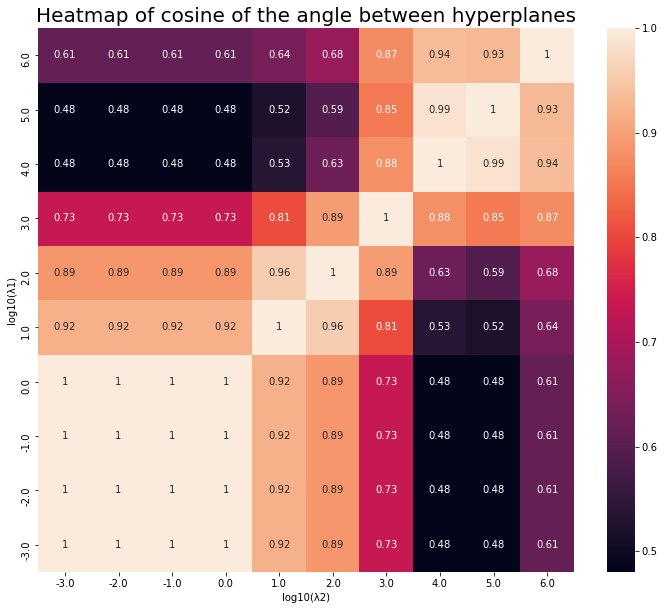

In [363]:
# plot heatmap
df_heatmap = pd.DataFrame(np.log10(combination_list_lambda), columns=["log10(λ1)","log10(λ2)"])
df_heatmap["cosine angle"] = cosine_angle_list
df_heatmap = df_heatmap.pivot("log10(λ1)", "log10(λ2)", "cosine angle")
fig, ax = plt.subplots(figsize=(12,10)) 
sns.heatmap(df_heatmap, annot=True)
plt.title("Heatmap of cosine of the angle between hyperplanes", fontsize=20)
ax.invert_yaxis()

2.2.3

The function `svm_scores` computes precision and F-score of the predicted values of y.

In [364]:
def svm_scores(w, X_test, y_test):
    y_pred = np.sign(X_test @ w)
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(y_test)):
        if y_pred[i] == y_test[i] == 1:
            TP +=1
        elif y_pred[i] == 1 and y_test[i] == -1:
            FP +=1
        elif y_pred[i] == -1 and y_test[i] == 1:
            FN += 1
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F_score = 2 * precision * recall / (precision + recall)
    return precision, F_score

We will now retrain the model on the entire training dataset using the optimal $\lambda$ found above.

In [365]:
# Compute accuracy, precision and F-score
best_w = sgd(X_d_train_svm, y_d_train_svm.to_numpy(), max_iterations=10000, stop_criterion=0.001, learning_rate=1e-5, regul_strength=best_lambda)
acc_train_svm = svm_accuracy(best_w, X_d_train_svm, y_d_train_svm.to_numpy())
acc_test_svm = svm_accuracy(best_w, X_d_test_svm, y_d_test_svm.to_numpy())
scores_train_svm = svm_scores(best_w, X_d_train_svm, y_d_train_svm.to_numpy())
scores_test_svm = svm_scores(best_w, X_d_test_svm, y_d_test_svm.to_numpy())

In [366]:
# Table of linear SVM scores
data_svm = {'Accuracy': [acc_train_svm, acc_test_svm], 'Precision': [scores_train_svm[0], scores_test_svm[0]], 'F-score':[scores_train_svm[1], scores_test_svm[1]]}
df_svm = pd.DataFrame(data_svm, index=['Training', 'Test'])
df_svm = df_svm.style.set_properties(**{'font-size': '14pt'})
df_svm = df_svm.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_svm

,Accuracy,Precision,F-score
Training,0.926740,0.833333,0.750000
Test,0.931624,0.833333,0.714286


From the table above, we observe that the precision and F-score on the test set is relatively low compared to the accuracy on the test set. This implies that the soft-margin linear SVM is sensitive to imbalanced datasets, where the high accuracy is due to the fact that the majority class only is well predicted, whereas the low precision and F-score conveys that the minority class is not well predicted. There is also slight underfitting as the accuracy on the test set is slightly higher than the accuracy and precision on the training set.

2.2.4

The function `kernel_matrix` computes the sigmoid kernel using the formula below:
$$k(x^{(i)},x^{(j)}|\sigma)=\tanh(\sigma(x^{(i)} \cdot x^{(j)})+1)$$

In [367]:
def kernel_matrix(X1, X2, sigma):

    n1,m1 = X1.shape
    n2,m2 = X2.shape
    kernel = np.zeros((n1,n2))

    # Here we define a sigmoid Kernel #
    for i in range(n1):
        kernel[i,:] = np.tanh(sigma * np.dot(X2, X1[i]) + 1) 
        
    return kernel

We aim to minimise the loss function for the soft-margin kernelised SVM classifier:
$$L(\mathbf{u},b) = \frac{1}{2}\mathbf{u}^{\rm{T}}\mathbf{K} \mathbf{u} + \lambda \sum_{i=1}^N  \max \Big\{0, 1-y^{(i)}(\mathbf{K}^{(i)}\mathbf{u} + b)\Big\}$$
The `compute_cost_kernel` function computes the cost using the formula above.

In [368]:
def compute_cost_kernel(u, K, y, intercept, regul_strength=10):
    
    distances = 1 - (y)*(K@u + intercept)
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = regul_strength * np.sum(distances)

    # calculate cost
    return 0.5 * np.dot(u, K@u) + hinge

The function `calculate_cost_gradient_kernel` computes the gradients of the cost with respect to $\boldsymbol w$ and b.

In [369]:
def calculate_cost_gradient_kernel(u, K_batch, y_batch, intercept, regul_strength=10):

    # if only one example is passed
    if type(y_batch) == np.float64 or type(y_batch) == np.int32:
        y_batch = np.asarray([y_batch])
        K_batch = np.asarray([K_batch])  # gives multidimensional array
    
    distance = 1 - (y_batch * (K_batch @ u + intercept))
    dw = np.zeros(len(u))
    db = 0

    # define the gradient with the hinge loss 
    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = K_batch@u / len(y_batch)
            dj = 0
        else:
            di = K_batch@u / len(y_batch) - (regul_strength * y_batch[ind] * K_batch[ind])
            dj = - regul_strength * y_batch[ind]
        dw += di
        db += dj

    return dw, db

The function `sgd_kernel` performs stochastic gradient descent to find $\boldsymbol w$ and b.

In [370]:
def sgd_kernel(K, y, batch_size=32, max_iterations=4000, stop_criterion=0.001, learning_rate=1e-4, regul_strength=10, print_outcome=False):

    # initialise zero u and intercept
    u = np.zeros(K.shape[1])
    intercept=0
    
    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf
    
    # stochastic gradient descent
    indices = np.arange(len(y))
    for iteration in range(1, max_iterations):
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        batch_idx = indices[:batch_size]
        K_b, y_b = K[batch_idx], y[batch_idx]
        for ki, yi in zip(K_b, y_b):
            ascent, ascent_b = calculate_cost_gradient_kernel(u, ki, yi, intercept, regul_strength)
            u = u - (learning_rate * ascent)
            intercept = intercept - (learning_rate * ascent_b)
        
        # convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:
            # compute cost
            cost = compute_cost_kernel(u, K, y, intercept, regul_strength)
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return u, intercept
            
            prev_cost = cost
            nth += 1
    
    return u, intercept

We now train the soft margin kernelised SVM classifier by fixing $\lambda=10$ for σ=0.01, 0.1, 1, 2.

In [389]:
b_list = []
for sigma in [0.01, 0.1, 1, 2]:
    
    K_train = kernel_matrix(X_d_train_s.to_numpy(), X_d_train_s.to_numpy(), sigma)

    u, b = sgd_kernel(K_train, y_d_train_svm.to_numpy(), batch_size=128, max_iterations=10000, stop_criterion=1e-4, learning_rate=1e-7, regul_strength=10, print_outcome=False)
    
    b_list.append(b)
    # print("σ = {}: intercept b = {}".format(sigma, b))

In [390]:
# Table of value of intercept b given σ
data_b = {'b': b_list}
df_b = pd.DataFrame(data_b, index= ['σ = 0.01', 'σ = 0.1', 'σ = 1', 'σ = 2'])
df_b = df_b.style.set_properties(**{'font-size': '14pt'})
df_b = df_b.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_b

,b
σ = 0.01,-0.014134
σ = 0.1,-0.168046
σ = 1,-0.339007
σ = 2,-0.429159


2.2.5

The function `svm_k_scores` computes the accuracy, precision and F-score of the soft margin kernelised SVM classifier.

In [391]:
def svm_k_scores(u, X, y_test, sigma, intercept):
    K_test = kernel_matrix(X, X_d_train_s.to_numpy(), sigma)
        
    y_pred = np.sign(K_test@u + intercept)
    
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(y_test)):
        if y_pred[i] == y_test[i] == 1:
            TP +=1
        elif y_pred[i] == 1 and y_test[i] == -1:
            FP +=1
        elif y_pred[i] == -1 and y_test[i] == 1:
            FN += 1
        else:
            TN += 1
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    recall = TP / (TP + FN)
    if (TP + FP) == 0:
        precision = None
        F_score = None
    else:
        precision = TP / (TP + FP)
        F_score = 2 * precision * recall / (precision + recall)
    return accuracy, precision, F_score

In [392]:
a_train_list = []
p_train_list = []
f_train_list = []
a_test_list = []
p_test_list = []
f_test_list = []

for sigma in [0.01, 0.1, 1, 2]:
    
    # print('For sigma = ' + str(sigma))
    K_train = kernel_matrix(X_d_train_s.to_numpy(), X_d_train_s.to_numpy(), sigma)

    u, b = sgd_kernel(K_train, y_d_train_svm.to_numpy(), batch_size=128, max_iterations=10000, stop_criterion=1e-4, learning_rate=1e-7, regul_strength=10, print_outcome=False)
    
    scores_train_svm_k = svm_k_scores(u, X_d_train_s.to_numpy(), y_d_train_svm.to_numpy(), sigma, b)
    scores_test_svm_k = svm_k_scores(u, X_d_test_s.to_numpy(), y_d_test_svm.to_numpy(), sigma, b)
    
    a_train_list.append(scores_train_svm_k[0])
    p_train_list.append(scores_train_svm_k[1])
    f_train_list.append(scores_train_svm_k[2])
    a_test_list.append(scores_test_svm_k[0])
    p_test_list.append(scores_test_svm_k[1])
    f_test_list.append(scores_test_svm_k[2])

In [393]:
# Table of SVM scores
data_svm_all = {'Accuracy': [acc_test_svm, a_test_list[0], a_test_list[1], a_test_list[2], a_test_list[3]], 
                'Precision': [scores_test_svm[0], p_test_list[0], p_test_list[1], p_test_list[2], p_test_list[3]], 
                'F-score': [scores_test_svm[1], f_test_list[0], f_test_list[1], f_test_list[2], f_test_list[3]]}
df_svm_all = pd.DataFrame(data_svm_all, index=['Linear SVM', 'Kernelised SVM (σ = 0.01)', 'Kernelised SVM (σ = 0.1)', 'Kernelised SVM (σ = 1)', 'Kernelised SVM (σ = 2)'])
df_svm_all = df_svm_all.style.set_properties(**{'font-size': '14pt'})
df_svm_all = df_svm_all.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_svm_all

,Accuracy,Precision,F-score
Linear SVM,0.931624,0.833333,0.714286
Kernelised SVM (σ = 0.01),0.863248,nan,nan
Kernelised SVM (σ = 0.1),0.863248,nan,nan
Kernelised SVM (σ = 1),0.905983,0.666667,0.645161
Kernelised SVM (σ = 2),0.905983,0.666667,0.645161


The precision and F-score when $\sigma=0.01$ and $\sigma=0.1$ is undefined as only the majority class is predicted. This implies that SVM is sensitive to imbalance datasets for small $\sigma$.<br>
The linear SVM model outperforms all the other kernelised SVM models as it has the highest accuracy, precision and F-score. Thus, we can infer that the data points are separable by a hyperplane in d-dimensional space. The $\sigma$ and $\lambda$ hyperparameter should be optimised through cross-validation or grid search to further improve the performance of the kernelised SVM. The type of kernel can also be optimised through cross-validation or grid search.